# Exploratory Data Analysis and Feature Extraction
***

# Installing Packages and Libraries

In [1]:
# Uncomment to upgrade packages
# %pip install pandas
# %pip install scipy
# %pip install numpy
# %pip install statsmodels
# %pip install seaborn
# %pip install ucimlrepo

In [2]:
#%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from collections import Counter
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings

# Disable all warnings
warnings.filterwarnings("ignore")

In [3]:
# extra imports
from pandas import read_csv
from scipy.stats import boxcox, shapiro, chi2, chi2_contingency
from matplotlib import patches
import seaborn as sns

***
# Defining Functions

In [4]:
def print_categorical_variables(df):
    categorical_vars = df.select_dtypes(include=['object', 'category']).columns
    print("Categorical Variables:")
    for var in categorical_vars:
        categories = df[var].unique()
        categories_str = [str(category) for category in categories]  # Convert to str
        print(f"{var}: {', '.join(categories_str)}")

def print_numerical_variables(df):
    numerical_vars = df.select_dtypes(exclude=['object', 'category']).columns
    print("Numerical Variables:")
    for var in numerical_vars:
        print(var)

def split_cat_num_columns(df):
    #Split for further analysis between categorical and numerical variables
    cat_cols = []
    num_cols = []

    for col in df.columns:
        if df[col].dtype in ['object', 'category']:
            cat_cols.append(col)
        else:
            num_cols.append(col)
    return cat_cols, num_cols

def plot_dataframe(df, x=4, y =4):
    
    cat_cols, _ = split_cat_num_columns(df)
    
    # Define custom color palette
    colors = ['#648E9C', '#9CB1BC', '#C5D4DE', '#E8F1F4']

    # Create figure and axes
    fig, axes = plt.subplots(x, y, figsize=(18, 16))

    # Set axis labels font properties
    font_props = {'fontsize': 10}

    # Plot each variable
    for i, col in enumerate(df.columns):
        ax = axes.reshape(-1)[i]
        if col in cat_cols:
            sns.countplot(x=col, data=df, ax=ax, palette=colors)
            ax.set_xlabel(col, fontdict=font_props)
            ax.set_ylabel('Count', fontdict=font_props)

            # Add numbers on top of the bars
            for p in ax.patches:
                ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                            ha='center', va='bottom', xytext=(0, 5), textcoords='offset points', fontsize=8)
        else:
            sns.histplot(x=col, data=df, ax=ax, color=colors[0], kde=True, stat="density")
            kde_color = '#9C648E'  # Desired color for the Gaussian curves
            sns.kdeplot(x=col, data=df, ax=ax, color=kde_color, lw=1.5)
            ax.set_xlabel(col, fontdict=font_props)
            ax.set_ylabel('Density', fontdict=font_props)

        # Rotate x-axis labels
        ax.tick_params(axis='x', labelrotation=45)
        ax.tick_params(axis='both', labelsize=8)

        # Adjust y-axis limit to leave space for the numbers
        ax.set_ylim(0, ax.get_ylim()[1] * 1.15)

    # Adjust spacing between subplots
    plt.tight_layout(pad=2.0)

    # Display the plot without the messages
    plt.show();
    
def calculate_outliers(data, column):
    q1 = np.percentile(data[column], 25)
    q3 = np.percentile(data[column], 75)
    iqr = q3 - q1

    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    outliers = data[column][(data[column] < lower_bound) | (data[column] > upper_bound)]
    extreme_outliers = data[column][(data[column] < q1 - 3 * iqr) | (data[column] > q3 + 3 * iqr)]

    return q1, q3, iqr, lower_bound, upper_bound, outliers, extreme_outliers

def plot_boxplot_histogram(data, column):
    # Define custom color palette
    colors = ['#648E9C', '#9CB1BC', '#C5D4DE', '#E8F1F4']

    # Calculate outliers and extreme outliers
    q1, q3, iqr, lower_bound, upper_bound, outliers, extreme_outliers = calculate_outliers(data, column)

    # Create subplots with custom width ratios and figure size
    fig, axes = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 4]}, figsize=(9, 5))

    # Box plot
    boxplot = axes[0].boxplot(data[column], showfliers=True)
    axes[0].set_title(f'{column} - Box Plot', fontsize=12)
    axes[0].set_ylabel(f'{column}', fontsize=10)
    
    # Plot the boundary lines for outliers in the box plot if they exist
    if outliers.any():
        axes[0].axhline(lower_bound, color='#9C648E', linestyle='--')
        axes[0].axhline(upper_bound, color='#9C648E', linestyle='--')
    
    # Plot the boundary lines for extreme outliers in the box plot if they exist
    if extreme_outliers.any():
        axes[0].axhline(lower_bound - 3 * iqr, color='#3F51B5', linestyle='--')
        axes[0].axhline(upper_bound + 3 * iqr, color='#3F51B5', linestyle='--')

    # Change color of extreme outliers to blue
    for flier in boxplot['fliers']:
        flier.set(marker='o', color='#3F51B5', alpha=0.5)

    # Histogram
    hist = sns.histplot(data=data, x=column, ax=axes[1], color=colors[0])
    axes[1].set_title(f'{column} - Histogram', fontsize=12)
    axes[1].set_xlabel(f'{column}', fontsize=10)
    axes[1].set_ylabel('Frequency', fontsize=10)

    # Plot the boundary lines for outliers in the histogram if they exist
    if outliers.any():
        hist.axvline(lower_bound, color='#9C648E', linestyle='--')
        hist.axvline(upper_bound, color='#9C648E', linestyle='--')
    
    # Plot the boundary lines for extreme outliers in the histogram if they exist
    if extreme_outliers.any():
        hist.axvline(lower_bound - 3 * iqr, color='#3F51B5', linestyle='--')
        hist.axvline(upper_bound + 3 * iqr, color='#3F51B5', linestyle='--')

    # Create legend for the plot
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='#9C648E', linestyle='--', markersize=5, label='Outlier Boundary'),
        plt.Line2D([0], [0], marker='o', color='#3F51B5', linestyle='--', markersize=5, alpha=0.5, label='Extreme Outlier')
    ]
    axes[1].legend(handles=legend_elements, loc='upper right')

    # Adjust tick label font size for both subplots
    for ax in axes:
        ax.tick_params(axis='both', labelsize=8)

    # Adjust spacing between subplots
    plt.tight_layout()

    # Display the plot
    plt.show();

def print_outlier_analysis(column, q1, q3, iqr, lower_bound, upper_bound, outliers, extreme_outliers):
    print("{} Outlier Analysis:".format(column))
    print("-----------------------------")
    print("First Quartile (Q1): {:.2f}".format(q1))
    print("Third Quartile (Q3): {:.2f}".format(q3))
    print("Interquartile Range (IQR): {:.2f}".format(iqr))
    print("Lower Bound: {:.2f}".format(lower_bound))
    print("Upper Bound: {:.2f}".format(upper_bound))
    print(f"Outliers Length: {len(outliers)}")
    print(f"Extreme Outliers Length: {len(extreme_outliers)}")
    
def bivariate_numerical_exploratory_analysis(df, target):
    plt.rcParams['font.size']= 10
    colors = ['#648E9C', '#9C648E']
    sns.pairplot(df, hue=target, palette=colors, plot_kws={'alpha': 0.75});

def plot_categorical_variables(data, target):
    categorical_vars = data.select_dtypes(include=['object', 'category']).columns

    num_plots = len(categorical_vars)
    num_cols = 3  # Number of columns in the subplot grid
    num_rows = (num_plots - 1) // num_cols + 1

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))
    axes = axes.flatten()
    for i, var in enumerate(categorical_vars):
        sns.countplot(x=var, hue=target, data=data, ax=axes[i], palette=["#648E9C", "#9C648E"])
        axes[i].set_title(f'{var} vs {target}')
        axes[i].set_xlabel(var)
        axes[i].set_ylabel('Count')
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
        axes[i].legend(title=target)

    # Hide empty subplots
    for j in range(i + 1, num_plots):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show();

def correlation_heatmap(df):
    numeric_cols = df.select_dtypes(include='number')  # Select only numeric columns
    correlation = numeric_cols.corr()
    mask = np.triu(np.ones_like(correlation, dtype=bool))

    cmap = sns.color_palette(['#648E9C', '#9C648E'])
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation, annot=True, cmap=cmap, linewidths=0.5)
    plt.title('Correlation Matrix')
    # Rotate variable labels
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=45, ha='right')
    plt.show();

def generate_cross_tabulations(df, target_var):
    categorical_vars = df.select_dtypes(include=['object', 'category']).columns
    
    for var in categorical_vars:
        crosstab = pd.crosstab(df[var], df[target_var])
        row_sums = crosstab.sum(axis=0)
        col_sums = crosstab.sum(axis=1)
        
        print(f"Cross-tabulation for {var} and {target_var}:")
        print(crosstab)
        print("Row sums:")
        print(row_sums)
        print("Column sums:")
        print(col_sums)
        print("\n")

def perform_chi_squared_test(df, cat_cols):
    results = []
    
    for col1 in cat_cols:
        for col2 in cat_cols:
            if col1 != col2:
                contingency_table = pd.crosstab(df[col1], df[col2])
                chi2, p_value, _, _ = chi2_contingency(contingency_table)
                results.append((col1, col2, chi2, p_value))
    
    results_df = pd.DataFrame(results, columns=['Variable 1', 'Variable 2', 'Chi-square', 'P-value'])
    return results_df


***
# SECTION 1: Importing the Dataset `Bank Marketing` from UCI repository

In this first part we are going to load the dataset, explore it and get some first insights.

In [5]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
bank_marketing = fetch_ucirepo(id=222) 
  
# data (as pandas dataframes) 
X = bank_marketing.data.features 
y = bank_marketing.data.targets 

In [6]:
X.head()

age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married        NaN      no     1506     yes   no   
4   33           NaN   single        NaN      no        1      no   no   

  contact  day_of_week month  duration  campaign  pdays  previous poutcome  
0     NaN            5   may       261         1     -1         0      NaN  
1     NaN            5   may       151         1     -1         0      NaN  
2     NaN            5   may        76         1     -1         0      NaN  
3     NaN            5   may        92         1     -1         0      NaN  
4     NaN            5   may       198         1     -1         0      NaN

In [7]:
y.tail()

y
45206  yes
45207  yes
45208  yes
45209   no
45210   no

In [8]:
bank_marketing = pd.concat([X, y], axis=1)
bank_marketing.shape

(45211, 17)

As we can see, the dataset has **45211** observations and **17** columns (variables). Our target value is the 17th, which is the `Subscription Status` of the client and it can be binary (`yes` or `no`).

In [9]:
bank_marketing.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day_of_week', 'month', 'duration', 'campaign',
       'pdays', 'previous', 'poutcome', 'y'],
      dtype='object')

Below we can see the first 5 rows of the dataset in order to have a brief overview of the available data.

In [10]:
bank_marketing.head()

age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married        NaN      no     1506     yes   no   
4   33           NaN   single        NaN      no        1      no   no   

  contact  day_of_week month  duration  campaign  pdays  previous poutcome   y  
0     NaN            5   may       261         1     -1         0      NaN  no  
1     NaN            5   may       151         1     -1         0      NaN  no  
2     NaN            5   may        76         1     -1         0      NaN  no  
3     NaN            5   may        92         1     -1         0      NaN  no  
4     NaN            5   may       198         1     -1         0      NaN  no

***
# SECTION 2: Basic Inspection of the Dataset

To begin with, a quick look at the variables types is taking place. 

In [11]:
bank_marketing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          45211 non-null  int64 
 1   job          44923 non-null  object
 2   marital      45211 non-null  object
 3   education    43354 non-null  object
 4   default      45211 non-null  object
 5   balance      45211 non-null  int64 
 6   housing      45211 non-null  object
 7   loan         45211 non-null  object
 8   contact      32191 non-null  object
 9   day_of_week  45211 non-null  int64 
 10  month        45211 non-null  object
 11  duration     45211 non-null  int64 
 12  campaign     45211 non-null  int64 
 13  pdays        45211 non-null  int64 
 14  previous     45211 non-null  int64 
 15  poutcome     8252 non-null   object
 16  y            45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [12]:
nan_count = bank_marketing.isna().sum()

print(nan_count)

age                0
job              288
marital            0
education       1857
default            0
balance            0
housing            0
loan               0
contact        13020
day_of_week        0
month              0
duration           0
campaign           0
pdays              0
previous           0
poutcome       36959
y                  0
dtype: int64


As it was mentioned in the dataset's metadata, there are in total **17** variables, **7** of which are `numerical` and **11** `categorical`. Also, as it can be seen in the results of the previous command that there are `null` values (**missing values**) included in the dataset, specifically for the variables: `job, education, contact, poutcome`.

Before proceeding with the treatment of the `missing values`, we need to take a look at the distribution of the numerical variables, as well as the categories of the categorical variables in order to fully understand the content of the variables and their categories, as well as the nature of their missing values.

In [13]:
bank_marketing.describe()

age        balance   day_of_week      duration      campaign  \
count  45211.000000   45211.000000  45211.000000  45211.000000  45211.000000   
mean      40.936210    1362.272058     15.806419    258.163080      2.763841   
std       10.618762    3044.765829      8.322476    257.527812      3.098021   
min       18.000000   -8019.000000      1.000000      0.000000      1.000000   
25%       33.000000      72.000000      8.000000    103.000000      1.000000   
50%       39.000000     448.000000     16.000000    180.000000      2.000000   
75%       48.000000    1428.000000     21.000000    319.000000      3.000000   
max       95.000000  102127.000000     31.000000   4918.000000     63.000000   

              pdays      previous  
count  45211.000000  45211.000000  
mean      40.197828      0.580323  
std      100.128746      2.303441  
min       -1.000000      0.000000  
25%       -1.000000      0.000000  
50%       -1.000000      0.000000  
75%       -1.000000      0.000000  
max      871.000000    275.000000

The results here indicate that the `numerical variables` do not include any abnormally high maximums (e.g. 9999999), thus we can consider that the numerical variables luck of errors.

Some special cases are present only for the variables `balance` and `pdays`. It can be understood that the `min` value of `balance` being equal to **-8019** might refer to an erroneous case (will be analysed later). Additionally, for variable `pdays` the `min` value being equal to **-1** refers to cases, where the client was never been contacted before the current call described by the specific observation. Finally, from the statistics calculated one can understand that there are some outliers in some of the variables. For example in variable `duration`, the value **4918** (seconds) is extremely far from the rest of the distribution, meaning that the call of the marketing campaign call lasted around **82 minutes**. Outlier analysis is performed in the following sections.

Also, last contact duration (`duration`), which is counted in seconds, highly affects the **output target** (e.g., `if duration=0 then y='no'`). Yet, the duration is not known before a call is performed. Also, after the end of the call `y` is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model. For that reason we proceed with removing the attribute `duration`.

In [14]:
bank_marketing.drop('duration', axis=1, inplace=True)

In [15]:
bank_marketing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          45211 non-null  int64 
 1   job          44923 non-null  object
 2   marital      45211 non-null  object
 3   education    43354 non-null  object
 4   default      45211 non-null  object
 5   balance      45211 non-null  int64 
 6   housing      45211 non-null  object
 7   loan         45211 non-null  object
 8   contact      32191 non-null  object
 9   day_of_week  45211 non-null  int64 
 10  month        45211 non-null  object
 11  campaign     45211 non-null  int64 
 12  pdays        45211 non-null  int64 
 13  previous     45211 non-null  int64 
 14  poutcome     8252 non-null   object
 15  y            45211 non-null  object
dtypes: int64(6), object(10)
memory usage: 5.5+ MB


As for the `categorical variables` by executing the following command, one can take a look at the available categories of the variables. 

In [16]:
print_categorical_variables(bank_marketing)

Categorical Variables:
job: management, technician, entrepreneur, blue-collar, nan, retired, admin., services, self-employed, unemployed, housemaid, student
marital: married, single, divorced
education: tertiary, secondary, nan, primary
default: no, yes
housing: yes, no
loan: no, yes
contact: nan, cellular, telephone
month: may, jun, jul, aug, oct, nov, dec, jan, feb, mar, apr, sep
poutcome: nan, failure, other, success
y: no, yes


From the result, it can be concluded that the categorical variables, contain some erroneous categories. For the categorical variables which include missing values (`job, education, contact, poutcome`), imputation techniques need to be considered. However, if the percentage of erroneous or missing data for a specific variable is large enough (e.g. 70%) then the best solution would be to not consider it part of the analysis.

Firstly, column `poutcome` will be dropped since the missing values exceed the **80%** of the dataset's number of rows. At the same time, variable `contact` is missing a total of **29%** of the dataset, thus imputing the missing values in this case might introduce some bias. Thus, to deal with the missing values of `job, education, and contact` columns we will just replace `NA` values with a new category named `Unknown`. 

In [17]:
bank_marketing = bank_marketing.drop('poutcome', axis=1)
nan_count = bank_marketing.isna().sum()
print(nan_count)

age                0
job              288
marital            0
education       1857
default            0
balance            0
housing            0
loan               0
contact        13020
day_of_week        0
month              0
campaign           0
pdays              0
previous           0
y                  0
dtype: int64


Thus, after dropping those 2 variables we end up with **15** variables in total, **14** explanatory variables and a target one. **5** of the explanatory variables are `numerical`, **2** are `date` variables and **8** `categorical`. Finally, the target variable `y` is categorical as well.

With the following commands, we replace the missing valeus of the categorical variables, with a new category named `Unknown`.

In [18]:
# Fill remaining missing values with a default category (e.g., 'Unknown')
bank_marketing['job'].fillna('Unknown', inplace=True)
bank_marketing['education'].fillna('Unknown', inplace=True)
bank_marketing['contact'].fillna('Unknown', inplace=True)
nan_count = bank_marketing.isna().sum()
print(nan_count)

age            0
job            0
marital        0
education      0
default        0
balance        0
housing        0
loan           0
contact        0
day_of_week    0
month          0
campaign       0
pdays          0
previous       0
y              0
dtype: int64


Finally, a brief description of the available variables is taking place:

**Numerical Variables**:
- **age**: Age of the client
- **balance**: Average yearly balance in euros
- **campaign**: Number of contacts performed during this campaign
- **pdays**: Number of days that passed by after the client was last contacted from a previous campaign
- **previous**: Number of contacts performed before this campaign

**Date Variables**:
- **day_of_week**: date variable representing the last contact day of the week
- **month**: date variable representing the last contact month of the year

   
**Categorical Variables**:
- **job**: Occupation type of the client. It can be *admin., blue-collar, entrepreneur, housemaid, management, retired, self-employed, services, student, technician, unemployed, unknown*
- **marital**: Client’s marital status. It can be *divorced, married, single, unknown*. *Note*: divorced means *divorced* or *widowed*
- **education**: Refers to the the education level of the client. It can be *basic.4y, basic.6y, basic.9y, high school, illiterate, professional course, university degree, unknown*
- **default**: Refers to the fact that the client has credit or not in default
- **housing**: Describing whether the client has a housing loan 
- **loan**: Describing whether the client has a personal loan 
- **contact**: Representing the contact communication type. Categories: *cellular, telephone*
- **y**: target variable, binary, indicating whether the client has subscribed to a term deposit. It can be `yes` or `no`

Before moving to `Section 3`, it is important to mention that since the dataset contains observations of `three` years (May 2008 to November 2010), and we luck the information of the year of the `last contact`, it is impossible to combine `day_of_week` and `month` to find the real date of the last contact. This would be very usefull, in order to have the information if the call was done during the working days or the weekend..

***
# SECTION 3: Univariate Analysis

To begin with, we are deviding into two separate lists the column names of the `numerical` and `categorical` variables, respectively.

In [19]:
print_categorical_variables(bank_marketing)
print("\n")
print_numerical_variables(bank_marketing)

Categorical Variables:
job: management, technician, entrepreneur, blue-collar, Unknown, retired, admin., services, self-employed, unemployed, housemaid, student
marital: married, single, divorced
education: tertiary, secondary, Unknown, primary
default: no, yes
housing: yes, no
loan: no, yes
contact: Unknown, cellular, telephone
month: may, jun, jul, aug, oct, nov, dec, jan, feb, mar, apr, sep
y: no, yes


Numerical Variables:
age
balance
day_of_week
campaign
pdays
previous


Once the variables have been separated into `categorical` and `numerical`, it is possible to create a single plot containing all the `histograms` of the numerical variables and the `countplots` of the categorical variables. With the following visualisation, an initial overview of the distribution of the available variables is possible.

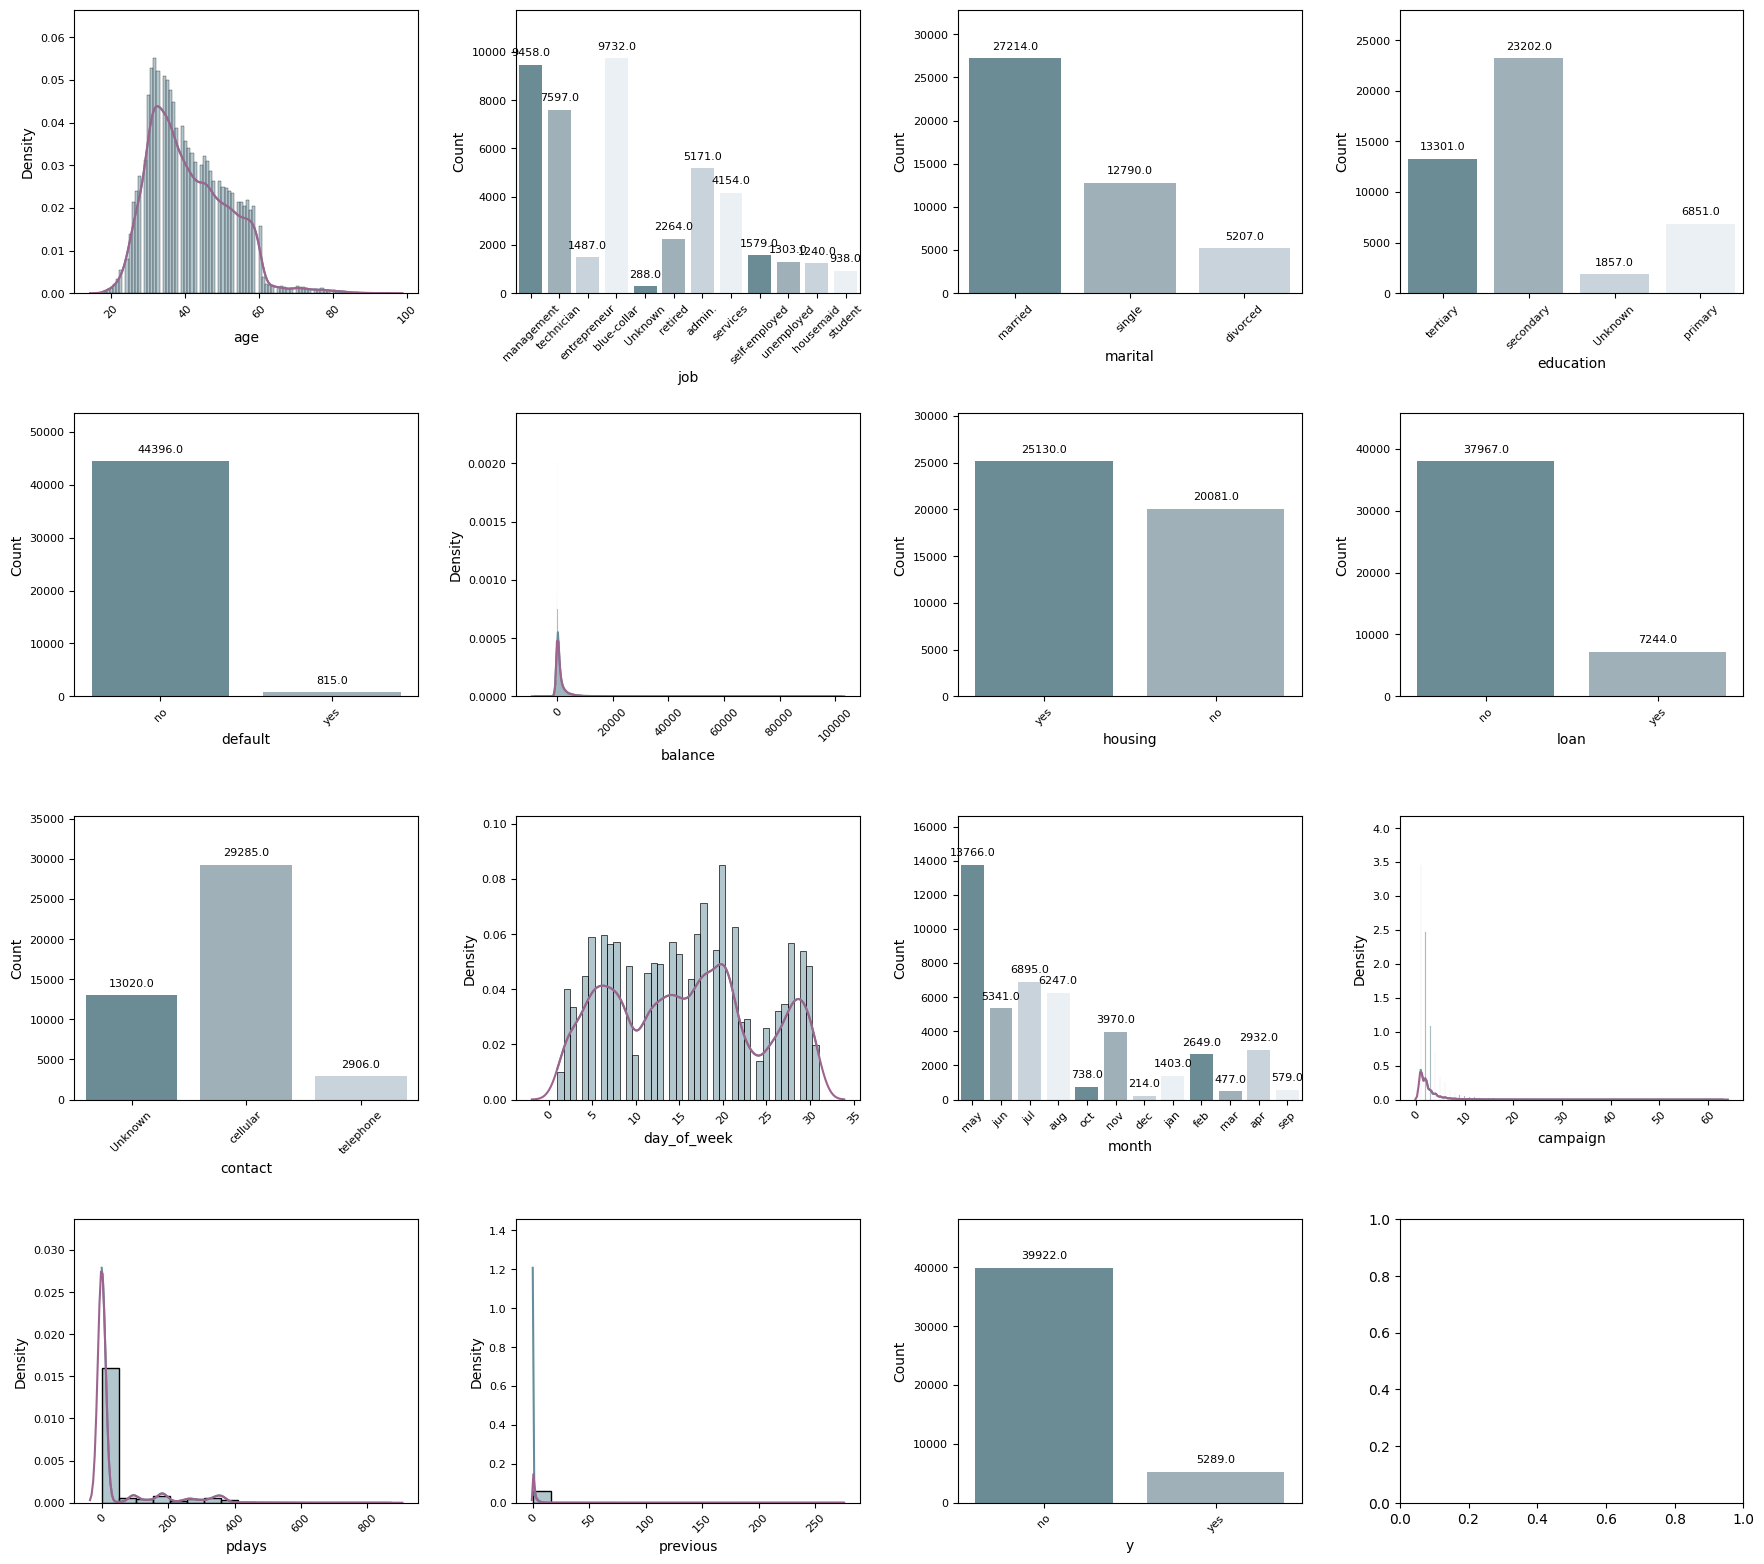

In [20]:
plot_dataframe(bank_marketing, 4, 4)

After analyzing the figures above, we can conclude that almost all of the variables have an unbalanced distribution. More speciffically:

Categorical Variables:
- `job`: The distribution of the client's jobs fluctuates from low values for specific job titles (**student, housemaid, student**), to very high ones for some others (**management, technician, blue-collar**).
- `marital`: Most of the clients in the dataset are `Married` and the difference between the groups is huge (**27214 married** compared to **12790 single** or **5207 divorced**).
- `education`: Most of the contacted clients have `secondary` education (**23202**), while the other education levels have considerably lower counts (**13301** for `tertiary`, **6851** for `primary`)
- `default`: **44396** clients do not have credit in default, compared to **815** that have 
- `housing`: Is quite balanced, with **25130** client's with housing loans, and **20081** without one.
- `loan`: Is unbalanced, with **37967** client's with personal loans, and **7244** without one.
- `contact`: The three categories are totally unbalanced, while the `telephone` one contains only **2906** observations, the `cellular` **29285**, and finally the `Unknown` (imputed) are **13020**.
- `month`: The `12` categories present high fluctuations. Most of the calls are being made between **May** and **August** compared to the rest of the year where the number of calls are way less.
- `y (Target Variable)`: The distribution is unbalacned for the target variable as well, since we obtain **39922** observations for `no` cases and **5289** for `yes`.

Numerical Variables:
- `age`: The distribution of age is quite fine, since there are several observation for mostly all the ages between **18** and **95** years old, although the mean value is around **40** years old.
- `balance`: The distribtuion of the clients' `average yearly balance in euros` is right-skewed, meaning that there are a lot of observations with small values, but at the same time there is a small number of observations with extrimely high values. This will lead to outliers and they need to be treated correctly.
- `day_of_week`: In this case the distribution is quite fine, presenting some autocorrelation, meaning that there are some repetitive patterns between week days, which makes sense. 
- `campaing`: It is right-skewed, thus observations with high values of `number of contacts performed during this campaign and for this client` need to be treated appropriately.
- `pdays`: Same is true for `pdays`. Observations with high values of `number of days that passed by after the client was last contacted from a previous campaign` need to be analysed more carefully.
- `previous`: The same happens for variable `previous`. Observations with high values of `number of contacts performed before this campaign and for this client`need to be taken into careful consideration.

The comments mentioned here need to be addressed in order to avoid fitting a learning algorithm which will generate a model described by high bias. For this reason, below the `Outliers Analysis` is included.

Before moving on to the `Outliers Analysis`, `Sharipo-normality` test is performed on the numerical values. In that way it can be statistically proven which numerical variables follow a normal distribution. Later in the `Bivariate Exploratory Analysis`, `Chi-Squared` tests are performed on the categorical variables as well, in order to check correlation between them.

## Shapiro Normality Test

In [21]:
cat_cols, num_cols = split_cat_num_columns(bank_marketing)
#Check the normality
shapiro_results = []
for column in num_cols:
    stat, p_value = shapiro(bank_marketing[column])
    shapiro_results.append((column, stat, p_value))

shapiro_df = pd.DataFrame(shapiro_results, columns=['Variable', 'Statistic', 'P_Value'])
print(shapiro_df)

      Variable  Statistic  P_Value
0          age   0.960546      0.0
1      balance   0.457170      0.0
2  day_of_week   0.959460      0.0
3     campaign   0.550732      0.0
4        pdays   0.474787      0.0
5     previous   0.235591      0.0


The results of the Shapiro-Wilk normality test reveal that **none of the numerical variables** (age, balance, day_of_week, campaign, pdays and previous) **exhibit a normal distribution**, as `indicated by the zero p-values` obtained. This suggests that these variables deviate significantly from a normal distribution. To mitigate potential issues during the modeling phase, it is considered to apply suitable transformations or utilizing non-parametric models that do not rely on normality assumptions.

However, taking into account our numerical variables and by looking at the generated figures, it looks like `balance` could be transformed into a normal distribution with the usage of logarithmic transformation or the boxcox function. Here are the results:

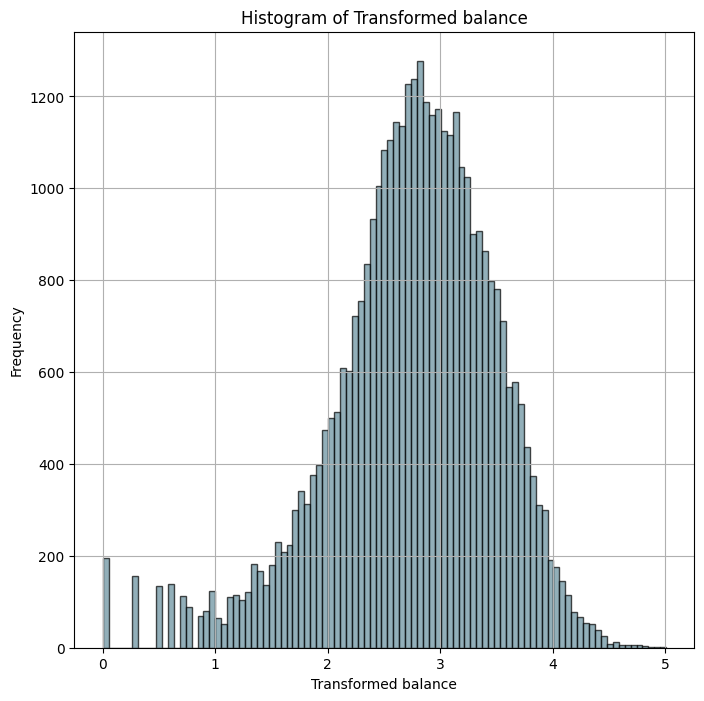

In [22]:
# Filter the DataFrame to exclude zero and negative values in 'duration'
filtered_balance = bank_marketing['balance'][bank_marketing['balance'] > 0]

# Apply log transformation to the filtered column
log_balance = filtered_balance.apply(np.log10)

# Plot the histogram of log-transformed values
log_balance.hist(bins='auto', figsize=(8, 8), color='#648E9C', alpha=0.7, edgecolor='black')
plt.xlabel('Transformed balance')
plt.ylabel('Frequency')
plt.title('Histogram of Transformed balance');

When `balance` is transformed using the logarithmic function, it `tends to follow a normal distribution`. This result can come in handy when we are dealing with modeling of the data. Let's check the same for variables `campaing, pdays and previous`.

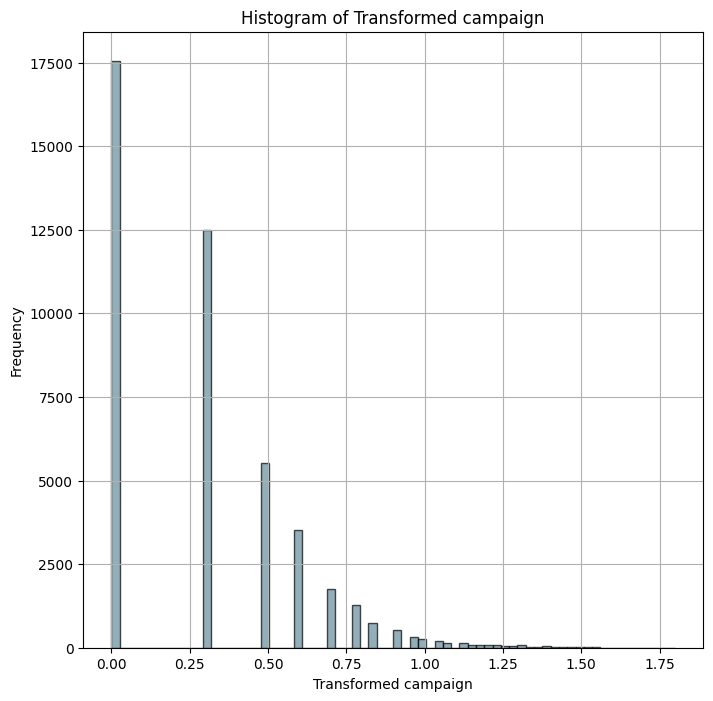

In [23]:
# Filter the DataFrame to exclude zero and negative values in 'campaign'
filtered_campaign = bank_marketing['campaign'][bank_marketing['campaign'] > 0]

# Apply log transformation to the filtered column
log_campaign = filtered_campaign.apply(np.log10)

# Plot the histogram of log-transformed values for 'campaign'
plt.figure(figsize=(8, 8))
log_campaign.hist(bins='auto', color='#648E9C', alpha=0.7, edgecolor='black')
plt.xlabel('Transformed campaign')
plt.ylabel('Frequency')
plt.title('Histogram of Transformed campaign')
plt.show();

From the previous histogram, it can be derived that the `logarithm of variable campaign seems to follow a power-law distribution`.

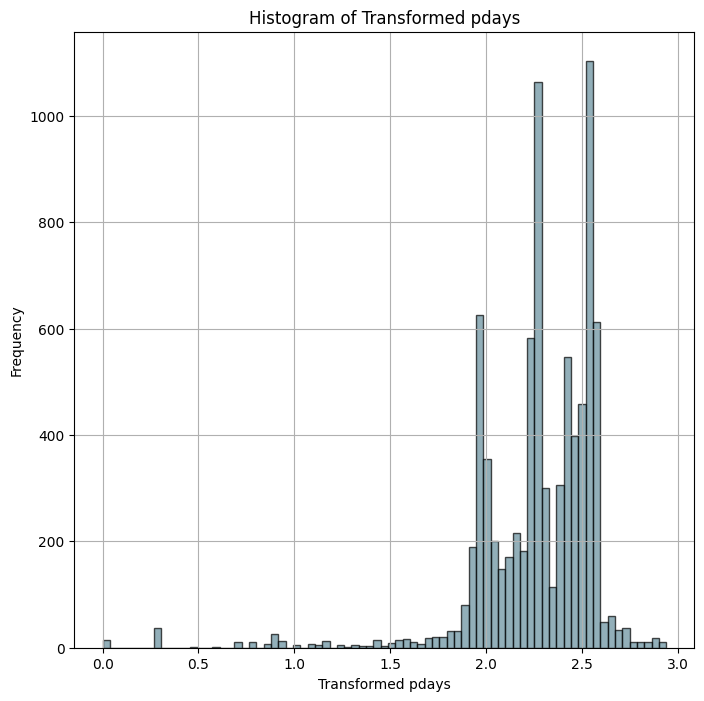

In [24]:
# Filter the DataFrame to exclude zero and negative values in 'pdays'
filtered_pdays = bank_marketing['pdays'][bank_marketing['pdays'] > 0]

# Apply log transformation to the filtered column
log_pdays = filtered_pdays.apply(np.log10)

# Plot the histogram of log-transformed values for 'pdays'
plt.figure(figsize=(8, 8))
log_pdays.hist(bins='auto', color='#648E9C', alpha=0.7, edgecolor='black')
plt.xlabel('Transformed pdays')
plt.ylabel('Frequency')
plt.title('Histogram of Transformed pdays')
plt.show();

logarithmic version of `pdays` could be described maybe from the mixture of 3 separte gaussians (by looking at the 3 picks of the histogram) 

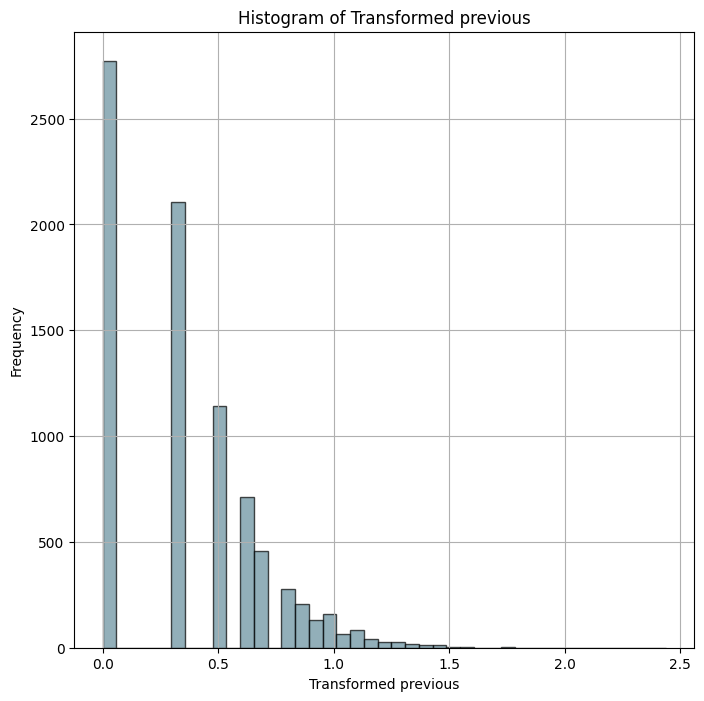

In [25]:
# Filter the DataFrame to exclude zero and negative values in 'previous'
filtered_previous = bank_marketing['previous'][bank_marketing['previous'] > 0]

# Apply log transformation to the filtered column
log_previous = filtered_previous.apply(np.log10)

# Plot the histogram of log-transformed values for 'previous'
plt.figure(figsize=(8, 8))
log_previous.hist(bins='auto', color='#648E9C', alpha=0.7, edgecolor='black')
plt.xlabel('Transformed previous')
plt.ylabel('Frequency')
plt.title('Histogram of Transformed previous')
plt.show();

From the previous histogram, it can also be derived that the `logarithm of variable previous seems to follow a power-law distribution`.

Let's see the results provided from `boxcox` as well.

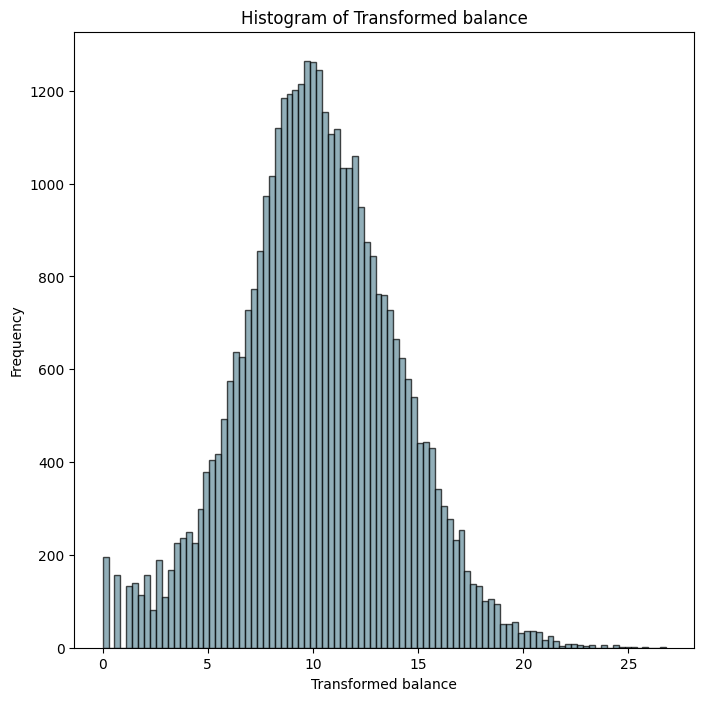

In [26]:
# Apply Box-Cox transformation to 'balance'
transformed_balance, lambda_balance = boxcox(filtered_balance)

# Create a new figure with the desired size
plt.figure(figsize=(8, 8))

# Plot the histogram of transformed 'balance'
plt.hist(transformed_balance, bins='auto', color='#648E9C', alpha=0.7, edgecolor='black')
plt.xlabel('Transformed balance')
plt.ylabel('Frequency')
plt.title('Histogram of Transformed balance')
plt.show();

In [27]:
lambda_balance

0.13018305423094695

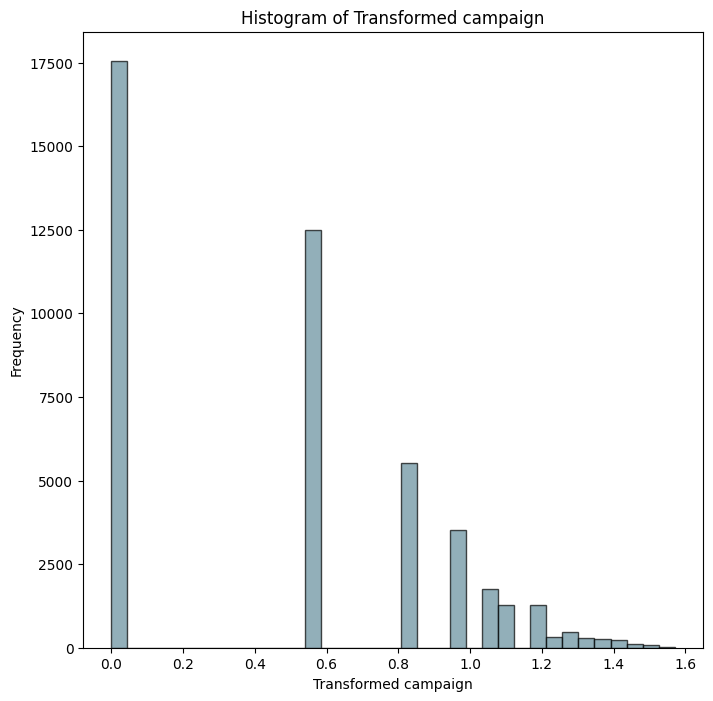

In [28]:
# Apply Box-Cox transformation to 'campaign'
transformed_campaign, lambda_campaign = boxcox(filtered_campaign)

# Create a new figure with the desired size
plt.figure(figsize=(8, 8))

# Plot the histogram of transformed 'campaign'
plt.hist(transformed_campaign, bins='auto', color='#648E9C', alpha=0.7, edgecolor='black')
plt.xlabel('Transformed campaign')
plt.ylabel('Frequency')
plt.title('Histogram of Transformed campaign')
plt.show();

In [29]:
lambda_campaign

-0.5785108891308647

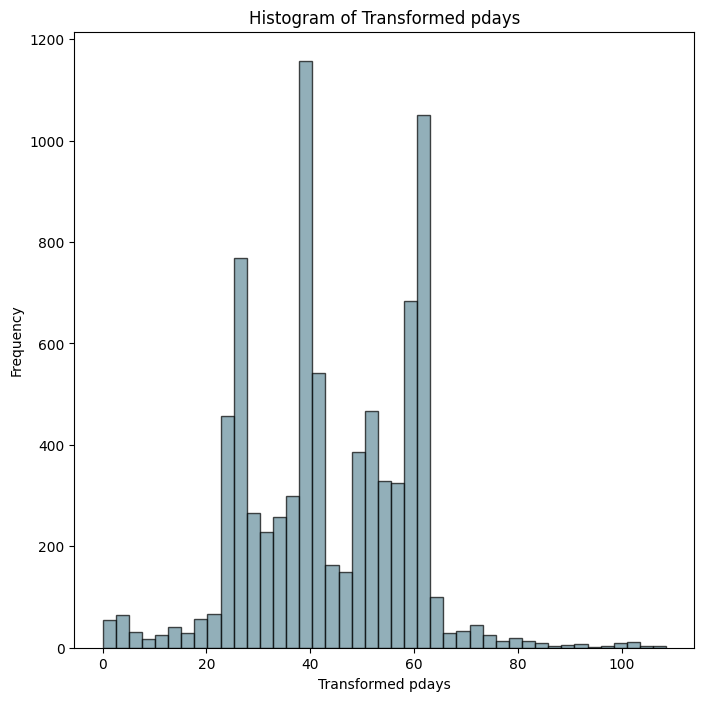

In [30]:
# Apply Box-Cox transformation to 'pdays'
transformed_pdays, lambda_pdays = boxcox(filtered_pdays)

# Create a new figure with the desired size
plt.figure(figsize=(8, 8))

# Plot the histogram of transformed 'pdays'
plt.hist(transformed_pdays, bins='auto', color='#648E9C', alpha=0.7, edgecolor='black')
plt.xlabel('Transformed pdays')
plt.ylabel('Frequency')
plt.title('Histogram of Transformed pdays')
plt.show();

In [31]:
lambda_pdays

0.6250882055145279

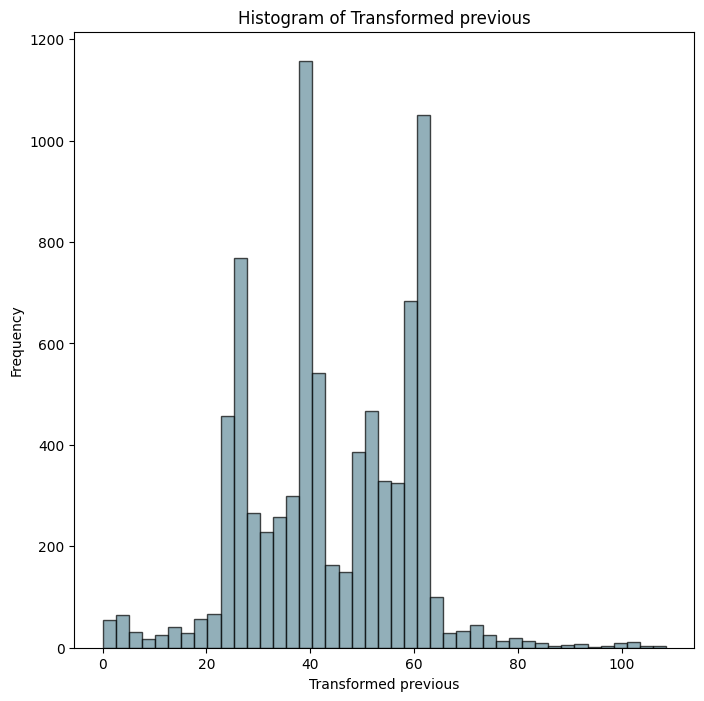

In [32]:
# Apply Box-Cox transformation to 'previous'
transformed_previous, lambda_previous = boxcox(filtered_previous)

# Create a new figure with the desired size
plt.figure(figsize=(8, 8))

# Plot the histogram of transformed 'previous'
plt.hist(transformed_pdays, bins='auto', color='#648E9C', alpha=0.7, edgecolor='black')
plt.xlabel('Transformed previous')
plt.ylabel('Frequency')
plt.title('Histogram of Transformed previous')
plt.show();

In [33]:
lambda_previous

-0.42721501114767646

Since the `lambda` variable is equal to `0.13` for variable `balance` it means that the transformation needed to be applied is the logarithmic (as previously shown). Also, for the variables `previous` and `campaing`, it could be usefull to take into consideration the power-law nature of their logarithmic transformation. 

Moreover, the outliers analysis and the extraction of new features will take place before we move on to preprocessing and normalizing the dataset. This decision is taken in order to check the correctness of the data, but in order to devide the preprocessing and normalization of the training and test data. In that way, we can be sure about the results of the model on the test data that would indicate if the model is able to generalize well or not, in new unseen cases. 

## Univariate Outliers Analysis

During the development and training of learning algorithms the inclusion of outliers can result in high bias results, thus it is very important to treat them carefully, first by identifying them and finally impute, remove, or just acknowledge their existence. The analysis is completed for all the numerical variables of the dataset. Firstly, `age` variable is being analyzed.

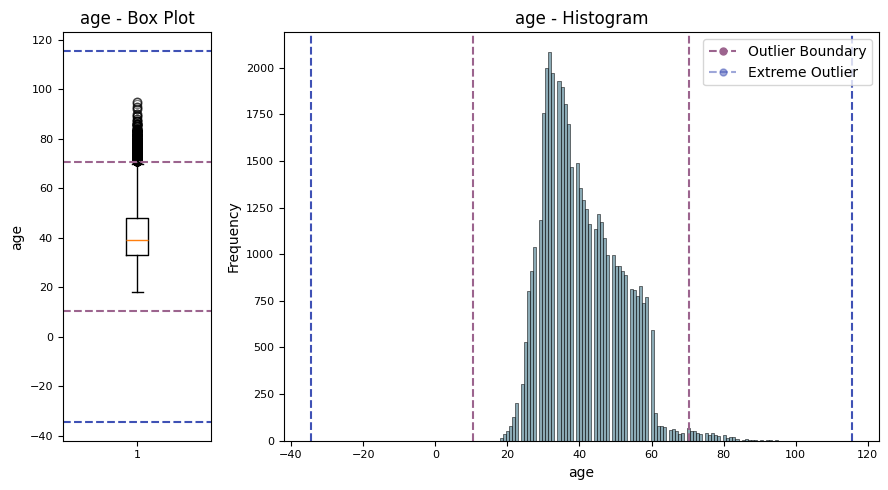

In [34]:
plot_boxplot_histogram(bank_marketing, 'age')

In [35]:
age_q1, age_q3, age_iqr, age_lower_bound, age_upper_bound, age_outliers, age_extreme_outliers = calculate_outliers(bank_marketing, 'age')
print_outlier_analysis('age', age_q1, age_q3, age_iqr, age_lower_bound, age_upper_bound, age_outliers, age_extreme_outliers)


age Outlier Analysis:
-----------------------------
First Quartile (Q1): 33.00
Third Quartile (Q3): 48.00
Interquartile Range (IQR): 15.00
Lower Bound: 10.50
Upper Bound: 70.50
Outliers Length: 487
Extreme Outliers Length: 3


Based on the `IQR` analyses, the methodology followed below is to discard `extreme outliers`. However, before doing so, a manual inspection is taking place for each variable, just to be sure that important information is not discarded. E.g. for variable `age` it can be seen that no `extreme outliers` occur, so we can move forward with the outliers analysis.

In [36]:
bank_marketing.loc[age_extreme_outliers.index]


age      job   marital  education default  balance housing loan  \
31233   94  retired  divorced  secondary      no     1234      no   no   
33699   95  retired  divorced    primary      no     2282      no   no   
41663   95  retired   married  secondary      no        0      no   no   

         contact  day_of_week month  campaign  pdays  previous    y  
31233   cellular            3   mar         1     -1         0   no  
33699  telephone           21   apr        17     -1         0  yes  
41663  telephone            1   oct         1     -1         0   no

In [37]:
bank_marketing.shape

(45211, 15)

For variable age, 3 extreme cases are present (clients with age **94 and 95**). However, retaining this 3 cases in the dataset, will not include a lot of bias to the model. Let's check the outliers for variable `balance`.

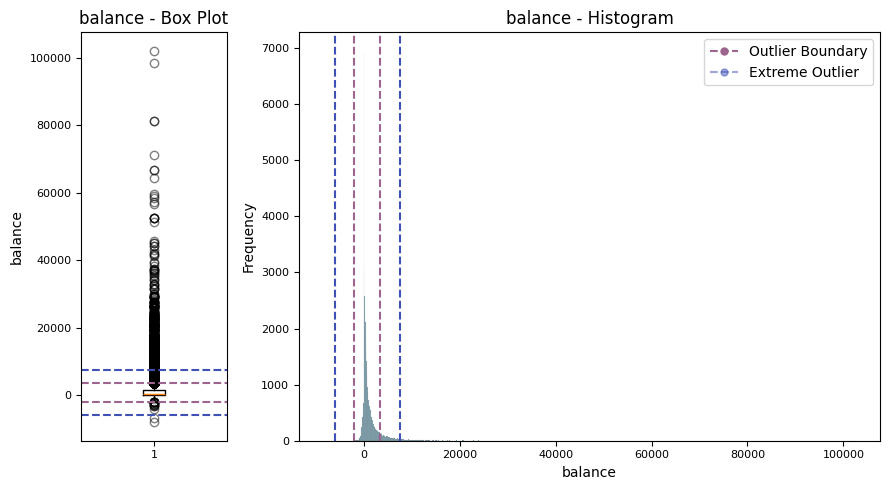

In [38]:
plot_boxplot_histogram(bank_marketing, 'balance')

In [39]:
bln_q1, bln_q3, bln_iqr, bln_lower_bound, bln_upper_bound, bln_outliers, bln_extreme_outliers = calculate_outliers(bank_marketing, 'balance')
print_outlier_analysis('balance', bln_q1, bln_q3, bln_iqr, bln_lower_bound, bln_upper_bound, bln_outliers, bln_extreme_outliers)

balance Outlier Analysis:
-----------------------------
First Quartile (Q1): 72.00
Third Quartile (Q3): 1428.00
Interquartile Range (IQR): 1356.00
Lower Bound: -1962.00
Upper Bound: 3462.00
Outliers Length: 4729
Extreme Outliers Length: 2443


So here for the variable `balance` we can see that there are **4729** outliers in total (starting from values of **3462.00** for the upper bound and **-1962.00** for the lower bound), from which **4729** are considered extreme outliers. By taking a look at the observations of extreme outlliers for `balance`, we consider of retaining all observations. Additionaly analysis about those cases will be completed during the modelling part of the project. More specifically:

In [40]:
bank_marketing['balance'].describe()

count     45211.000000
mean       1362.272058
std        3044.765829
min       -8019.000000
25%          72.000000
50%         448.000000
75%        1428.000000
max      102127.000000
Name: balance, dtype: float64

In [41]:
bln_outliers.describe()

count      4729.000000
mean       7539.743286
std        6317.738249
min       -8019.000000
25%        4323.000000
50%        5608.000000
75%        8266.000000
max      102127.000000
Name: balance, dtype: float64

In [42]:
bln_extreme_outliers.describe()

count      2443.000000
mean      10568.096193
std        7597.094706
min       -8019.000000
25%        6529.500000
50%        8136.000000
75%       11623.500000
max      102127.000000
Name: balance, dtype: float64

In [43]:
bank_marketing.loc[bln_extreme_outliers.index]

age          job  marital  education default  balance housing loan  \
34      51   management  married   tertiary      no    10635     yes   no   
65      51   management  married   tertiary      no     6530     yes   no   
69      35  blue-collar   single  secondary      no    12223     yes  yes   
70      57  blue-collar  married  secondary      no     5935     yes  yes   
205     50     services  married  secondary      no     5699     yes   no   
...    ...          ...      ...        ...     ...      ...     ...  ...   
45110   50   management  married   tertiary      no     8205     yes   no   
45118   78      retired  married    primary      no    14204      no   no   
45127   67  blue-collar  married  secondary      no    16353      no   no   
45181   46  blue-collar  married  secondary      no     6879      no   no   
45208   72      retired  married  secondary      no     5715      no   no   

         contact  day_of_week month  campaign  pdays  previous    y  
34       Unknown            5   may         1     -1         0   no  
65       Unknown            5   may         1     -1         0   no  
69       Unknown            5   may         1     -1         0   no  
70       Unknown            5   may         1     -1         0   no  
205      Unknown            5   may         2     -1         0   no  
...          ...          ...   ...       ...    ...       ...  ...  
45110  telephone           25   oct         3    508         1   no  
45118   cellular           26   oct         1    183         1   no  
45127   cellular           27   oct         2     -1         0   no  
45181   cellular           15   nov         2    118         3   no  
45208   cellular           17   nov         5    184         3  yes  

[2443 rows x 15 columns]

The following command is performed, just to have a look at client's with negative balance.

In [44]:
bank_marketing[bank_marketing['balance'] < 0]

age          job   marital  education default  balance housing loan  \
25      44       admin.   married  secondary      no     -372     yes   no   
28      46   management    single  secondary      no     -246     yes   no   
36      25  blue-collar   married  secondary      no       -7     yes   no   
37      53   technician   married  secondary      no       -3      no   no   
45      36       admin.    single    primary      no     -171     yes   no   
...    ...          ...       ...        ...     ...      ...     ...  ...   
44626   31     services    single  secondary      no     -205      no   no   
44629   28  blue-collar    single  secondary      no      -46     yes   no   
44836   33  blue-collar   married    primary      no     -195      no   no   
44908   48   management  divorced   tertiary      no     -130     yes   no   
44964   21  blue-collar    single    primary      no      -42      no   no   

        contact  day_of_week month  campaign  pdays  previous    y  
25      Unknown            5   may         1     -1         0   no  
28      Unknown            5   may         2     -1         0   no  
36      Unknown            5   may         1     -1         0   no  
37      Unknown            5   may         1     -1         0   no  
45      Unknown            5   may         1     -1         0   no  
...         ...          ...   ...       ...    ...       ...  ...  
44626  cellular            1   sep         1    579         1  yes  
44629  cellular            1   sep         1     92        14  yes  
44836   Unknown           20   sep         1     -1         0   no  
44908  cellular           29   sep         2     61         9   no  
44964   Unknown           10   oct         1     -1         0   no  

[3766 rows x 15 columns]

Considering that variable `balance` can take negative values, for client's being in debt, we will not proceed with dropping any of those cases. However, no information is provided from the dataset's metadata about the range of values for the specific variable. Following, the analysis of `day_of_week` is taking place.

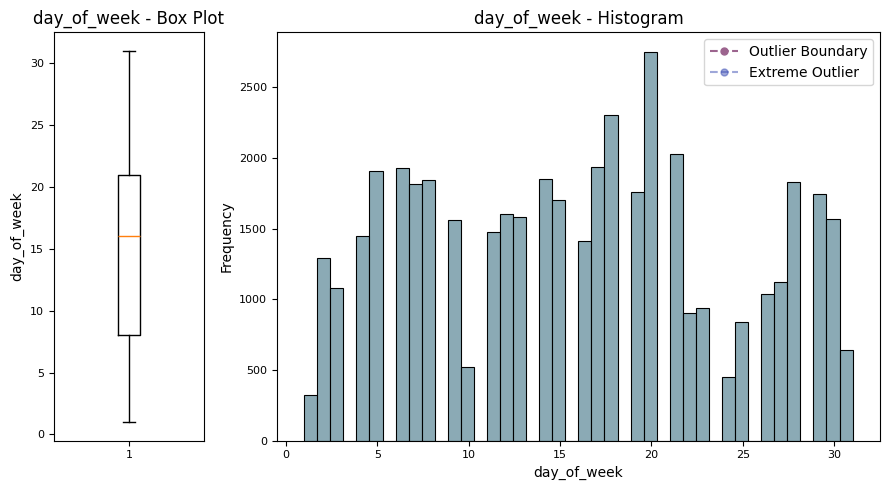

In [45]:
plot_boxplot_histogram(bank_marketing, 'day_of_week')

For `day_of_week` there are no outliers since all values range betwee integer values **1 - 31**. Next variable `campaign` is analyzed.

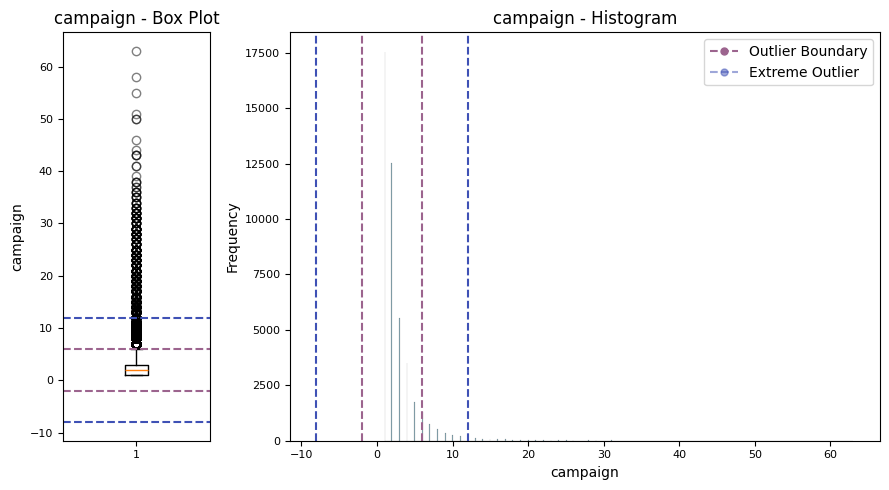

In [46]:
plot_boxplot_histogram(bank_marketing, 'campaign')

In [47]:
cmn_q1, cmn_q3, cmn_iqr, cmn_lower_bound, cmn_upper_bound, cmn_outliers, cmn_extreme_outliers = calculate_outliers(bank_marketing, 'campaign')
print_outlier_analysis('campaign', cmn_q1, cmn_q3, cmn_iqr, cmn_lower_bound, cmn_upper_bound, cmn_outliers, cmn_extreme_outliers)

campaign Outlier Analysis:
-----------------------------
First Quartile (Q1): 1.00
Third Quartile (Q3): 3.00
Interquartile Range (IQR): 2.00
Lower Bound: -2.00
Upper Bound: 6.00
Outliers Length: 3064
Extreme Outliers Length: 1462


For `campaign` we can see that there **3064** outliers in total (starting from values of **6** for the upper bound and **-2** for the lower bound), from which **1462** are considered extreme outliers.

In [48]:
bank_marketing['campaign'].describe()

count    45211.000000
mean         2.763841
std          3.098021
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         63.000000
Name: campaign, dtype: float64

In [49]:
cmn_outliers.describe()

count    3064.000000
mean       11.483355
std         6.021215
min         7.000000
25%         8.000000
50%         9.000000
75%        13.000000
max        63.000000
Name: campaign, dtype: float64

In [50]:
cmn_extreme_outliers.describe()

count    1462.000000
mean       15.579343
std         6.575955
min        10.000000
25%        11.000000
50%        13.000000
75%        18.000000
max        63.000000
Name: campaign, dtype: float64

In [51]:
bank_marketing.loc[cmn_extreme_outliers.index]

age           job   marital  education default  balance housing loan  \
2244    46   blue-collar   married    primary      no      633     yes   no   
2251    40    technician   married  secondary      no     2576     yes  yes   
2305    25        admin.    single  secondary      no        1     yes  yes   
2625    43   blue-collar   married    primary      no       17     yes   no   
2626    31    technician   married  secondary      no      106     yes   no   
...    ...           ...       ...        ...     ...      ...     ...  ...   
44100   70       retired  divorced  secondary      no     4572      no   no   
44231   32  entrepreneur   married   tertiary      no      762      no   no   
44583   24       student    single  secondary      no      431      no   no   
44594   34    technician    single   tertiary      no     2481      no   no   
44886   38    management   married   tertiary      no        0      no   no   

        contact  day_of_week month  campaign  pdays  previous    y  
2244    Unknown           12   may        10     -1         0   no  
2251    Unknown           12   may        11     -1         0   no  
2305    Unknown           12   may        12     -1         0   no  
2625    Unknown           13   may        10     -1         0   no  
2626    Unknown           13   may        13     -1         0   no  
...         ...          ...   ...       ...    ...       ...  ...  
44100  cellular            8   jul        11    162         5   no  
44231  cellular           19   jul        11     -1         0  yes  
44583  cellular           19   aug        11    185         5  yes  
44594  cellular           23   aug        16    192        14   no  
44886  cellular           24   sep        12    197         6   no  

[1462 rows x 15 columns]

By carefully, checking the statistics and some specific cases of both normal and extreme outliers of the variable `campaign`, it seems that all cases can be retained in the dataset. This conclusion is derived, since the variable is describing the number of contacts performed during this campaign and for this client, and all values (even for the extreme cases) the seem reasonable. Next, the analysis of `pdays` is completed.

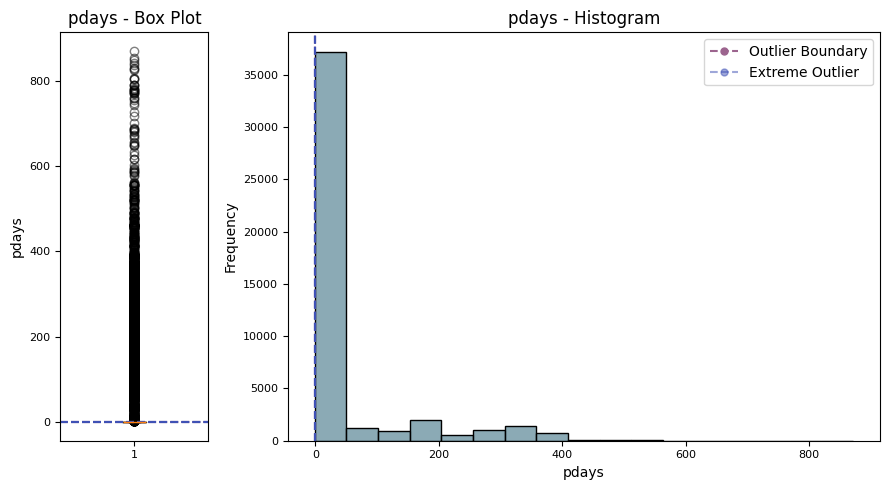

In [52]:
plot_boxplot_histogram(bank_marketing, 'pdays')

In [53]:
pdays_q1, pdays_q3, pdays_iqr, pdays_lower_bound, pdays_upper_bound, pdays_outliers, pdays_extreme_outliers = calculate_outliers(bank_marketing, 'pdays')
print_outlier_analysis('pdays', pdays_q1, pdays_q3, pdays_iqr, pdays_lower_bound, pdays_upper_bound, pdays_outliers, pdays_extreme_outliers)

pdays Outlier Analysis:
-----------------------------
First Quartile (Q1): -1.00
Third Quartile (Q3): -1.00
Interquartile Range (IQR): 0.00
Lower Bound: -1.00
Upper Bound: -1.00
Outliers Length: 8257
Extreme Outliers Length: 8257


So here for the variable `pdays` we can see that there are **8257** outliers in total (starting from values of **-1** for both the upper bound and the lower bound), from which **8257** are considered extreme outliers. Since this result does not seem reasonable, a more detailed look is required.

In [54]:
bank_marketing['pdays'].describe()

count    45211.000000
mean        40.197828
std        100.128746
min         -1.000000
25%         -1.000000
50%         -1.000000
75%         -1.000000
max        871.000000
Name: pdays, dtype: float64

When variable `pdays` is equal to **-1** it means that the client was never been contacted before. From the following result, we can see that this is the case for **36953** cases of the dataset.

In [55]:
bank_marketing[bank_marketing['pdays'] == -1]

age           job   marital  education default  balance housing loan  \
0       58    management   married   tertiary      no     2143     yes   no   
1       44    technician    single  secondary      no       29     yes   no   
2       33  entrepreneur   married  secondary      no        2     yes  yes   
3       47   blue-collar   married    Unknown      no     1506     yes   no   
4       33       Unknown    single    Unknown      no        1      no   no   
...    ...           ...       ...        ...     ...      ...     ...  ...   
45203   23       student    single   tertiary      no      113      no   no   
45205   25    technician    single  secondary      no      505      no  yes   
45206   51    technician   married   tertiary      no      825      no   no   
45207   71       retired  divorced    primary      no     1729      no   no   
45209   57   blue-collar   married  secondary      no      668      no   no   

         contact  day_of_week month  campaign  pdays  previous    y  
0        Unknown            5   may         1     -1         0   no  
1        Unknown            5   may         1     -1         0   no  
2        Unknown            5   may         1     -1         0   no  
3        Unknown            5   may         1     -1         0   no  
4        Unknown            5   may         1     -1         0   no  
...          ...          ...   ...       ...    ...       ...  ...  
45203   cellular           17   nov         1     -1         0  yes  
45205   cellular           17   nov         2     -1         0  yes  
45206   cellular           17   nov         3     -1         0  yes  
45207   cellular           17   nov         2     -1         0  yes  
45209  telephone           17   nov         4     -1         0   no  

[36954 rows x 15 columns]

Let's see what is true for the cases, where the client had been contacted before.

In [56]:
bank_marketing[bank_marketing['pdays'] != -1].describe()['pdays']

count    8257.000000
mean      224.577692
std       115.344035
min         1.000000
25%       133.000000
50%       194.000000
75%       327.000000
max       871.000000
Name: pdays, dtype: float64

In [57]:
pdays_outliers.describe()

count    8257.000000
mean      224.577692
std       115.344035
min         1.000000
25%       133.000000
50%       194.000000
75%       327.000000
max       871.000000
Name: pdays, dtype: float64

In [58]:
pdays_extreme_outliers.describe()

count    8257.000000
mean      224.577692
std       115.344035
min         1.000000
25%       133.000000
50%       194.000000
75%       327.000000
max       871.000000
Name: pdays, dtype: float64

We can see that, the number of client's that had been contacted before is the same as the number of outliers. For that reason, leaving out the client's having a value of **-1** for this variable, we conduct once more the outliers analysis.

In [59]:
pdays_filtered = bank_marketing[bank_marketing['pdays'] != -1]['pdays']

q1 = np.percentile(pdays_filtered, 25)
q3 = np.percentile(pdays_filtered, 75)
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = [(pdays_filtered < lower_bound) | (pdays_filtered > upper_bound)]
extreme_outliers = [(pdays_filtered < q1 - 3 * iqr) | (pdays_filtered > q3 + 3 * iqr)]

# Calculate statistics for outliers
num_outliers = outliers[0].sum();
percentage_outliers = num_outliers / len(pdays_filtered) * 100

# Calculate statistics for extreme outliers
num_extreme_outliers = extreme_outliers[0].sum();
percentage_extreme_outliers = num_extreme_outliers / len(pdays_filtered) * 100

outlier_stats = {
    'Number of Outliers': num_outliers,
    'Percentage of Outliers': percentage_outliers,
    'Lower Bound': lower_bound,
    'Upper Bound': upper_bound
}

extreme_outlier_stats = {
    'Number of Extreme Outliers': num_extreme_outliers,
    'Percentage of Extreme Outliers': percentage_extreme_outliers,
    'Q1 - 3*IQR': q1 - 3 * iqr,
    'Q3 + 3*IQR': q3 + 3 * iqr
}

print("Statistics for Outliers:")
for key, value in outlier_stats.items():
    print(f"{key}: {value}")

print("\nStatistics for Extreme Outliers:")
for key, value in extreme_outlier_stats.items():
    print(f"{key}: {value}")


Statistics for Outliers:
Number of Outliers: 49
Percentage of Outliers: 0.5934358725929514
Lower Bound: -158.0
Upper Bound: 618.0

Statistics for Extreme Outliers:
Number of Extreme Outliers: 0
Percentage of Extreme Outliers: 0.0
Q1 - 3*IQR: -449.0
Q3 + 3*IQR: 909.0


In [60]:
# Access the extreme outliers and outliers
extreme_outliers_values = pdays_filtered[extreme_outliers[0]].describe()
outliers_values = pdays_filtered[outliers[0]].describe()

# Print the extreme outliers and outliers
print("Extreme Outliers Statistics:")
print(extreme_outliers_values)

print("\nOutliers Statistics:")
print(outliers_values)

Extreme Outliers Statistics:
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: pdays, dtype: float64

Outliers Statistics:
count     49.000000
mean     747.591837
std       67.299368
min      626.000000
25%      686.000000
50%      769.000000
75%      792.000000
max      871.000000
Name: pdays, dtype: float64


From the previous analysis, we consider discrading all clients that had more than **626** to be called for a marketing campaing. Thus, we discard **49** cases leading to a final dataset with shape **(45163, 15)**

In [61]:
# Set the threshold value
threshold = pdays_filtered[outliers[0]].describe()['min']

# Create a boolean mask to identify rows where column 'pdays' is higher than the threshold
mask = bank_marketing['pdays'] > threshold

# Filter the DataFrame to keep only the rows where the condition is True
bank_marketing = bank_marketing[~mask]
bank_marketing = bank_marketing.reset_index(drop=True)
bank_marketing.head(10)
bank_marketing.shape

age           job   marital  education default  balance housing loan  \
0   58    management   married   tertiary      no     2143     yes   no   
1   44    technician    single  secondary      no       29     yes   no   
2   33  entrepreneur   married  secondary      no        2     yes  yes   
3   47   blue-collar   married    Unknown      no     1506     yes   no   
4   33       Unknown    single    Unknown      no        1      no   no   
5   35    management   married   tertiary      no      231     yes   no   
6   28    management    single   tertiary      no      447     yes  yes   
7   42  entrepreneur  divorced   tertiary     yes        2     yes   no   
8   58       retired   married    primary      no      121     yes   no   
9   43    technician    single  secondary      no      593     yes   no   

   contact  day_of_week month  campaign  pdays  previous   y  
0  Unknown            5   may         1     -1         0  no  
1  Unknown            5   may         1     -1         0  no  
2  Unknown            5   may         1     -1         0  no  
3  Unknown            5   may         1     -1         0  no  
4  Unknown            5   may         1     -1         0  no  
5  Unknown            5   may         1     -1         0  no  
6  Unknown            5   may         1     -1         0  no  
7  Unknown            5   may         1     -1         0  no  
8  Unknown            5   may         1     -1         0  no  
9  Unknown            5   may         1     -1         0  no

(45163, 15)

Finally, variable `previous` is being analysed.

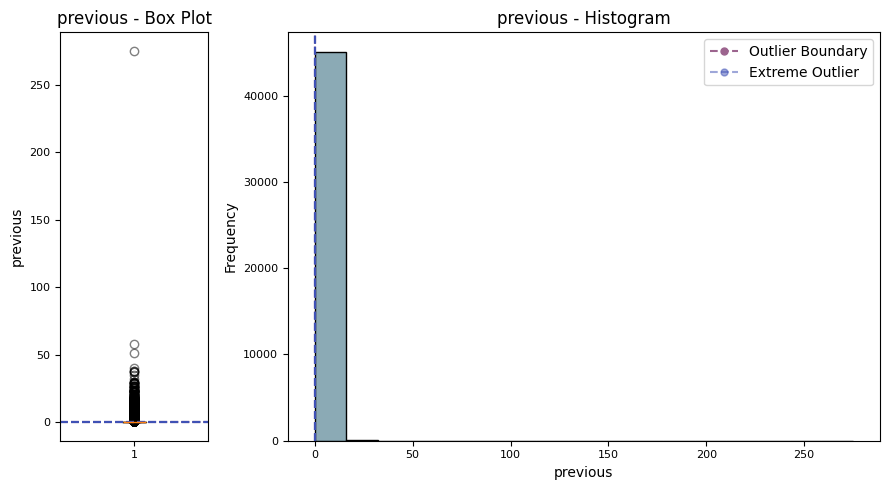

In [62]:
plot_boxplot_histogram(bank_marketing, 'previous')

In [63]:
prev_q1, prev_q3, prev_iqr, prev_lower_bound, prev_upper_bound, prev_outliers, prev_extreme_outliers = calculate_outliers(bank_marketing, 'previous')
print_outlier_analysis('previous', prev_q1, prev_q3, prev_iqr, prev_lower_bound, prev_upper_bound, prev_outliers, prev_extreme_outliers)

previous Outlier Analysis:
-----------------------------
First Quartile (Q1): 0.00
Third Quartile (Q3): 0.00
Interquartile Range (IQR): 0.00
Lower Bound: 0.00
Upper Bound: 0.00
Outliers Length: 8209
Extreme Outliers Length: 8209


In [64]:
bank_marketing[bank_marketing['previous'] != 0].describe()['previous']

count    8209.000000
mean        3.166159
std         4.514210
min         1.000000
25%         1.000000
50%         2.000000
75%         4.000000
max       275.000000
Name: previous, dtype: float64

In [65]:
prev_outliers.describe()

count    8209.000000
mean        3.166159
std         4.514210
min         1.000000
25%         1.000000
50%         2.000000
75%         4.000000
max       275.000000
Name: previous, dtype: float64

In [66]:
prev_extreme_outliers.describe()

count    8209.000000
mean        3.166159
std         4.514210
min         1.000000
25%         1.000000
50%         2.000000
75%         4.000000
max       275.000000
Name: previous, dtype: float64

The same seems to be happening here for variable `previous`. For that reason the same methodology will be followed for treating the outliers.

In [67]:
previous_filtered = bank_marketing[bank_marketing['previous'] != 0]['previous']

q1 = np.percentile(previous_filtered, 25)
q3 = np.percentile(previous_filtered, 75)
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = [(previous_filtered < lower_bound) | (previous_filtered > upper_bound)]
extreme_outliers = [(previous_filtered < q1 - 3 * iqr) | (previous_filtered > q3 + 3 * iqr)]

# Calculate statistics for outliers
num_outliers = outliers[0].sum();
percentage_outliers = num_outliers / len(previous_filtered) * 100

# Calculate statistics for extreme outliers
num_extreme_outliers = extreme_outliers[0].sum();
percentage_extreme_outliers = num_extreme_outliers / len(previous_filtered) * 100

outlier_stats = {
    'Number of Outliers': num_outliers,
    'Percentage of Outliers': percentage_outliers,
    'Lower Bound': lower_bound,
    'Upper Bound': upper_bound
}

extreme_outlier_stats = {
    'Number of Extreme Outliers': num_extreme_outliers,
    'Percentage of Extreme Outliers': percentage_extreme_outliers,
    'Q1 - 3*IQR': q1 - 3 * iqr,
    'Q3 + 3*IQR': q3 + 3 * iqr
}

print("Statistics for Outliers:")
for key, value in outlier_stats.items():
    print(f"{key}: {value}")

print("\nStatistics for Extreme Outliers:")
for key, value in extreme_outlier_stats.items():
    print(f"{key}: {value}")


Statistics for Outliers:
Number of Outliers: 448
Percentage of Outliers: 5.4574247776830305
Lower Bound: -3.5
Upper Bound: 8.5

Statistics for Extreme Outliers:
Number of Extreme Outliers: 145
Percentage of Extreme Outliers: 1.7663540017054453
Q1 - 3*IQR: -8.0
Q3 + 3*IQR: 13.0


After the same analysis for varialbe `previous`, we consider discarding all the observations for client's that were contacted more than **13** times before. The idea behind this decision, is to train a model which will be able to predict if a client will subscribe or not, without the need of the marketing employee calling an extreme number of times a specific client. For that reason, we are discarding **145** observations, leading to a final result of shape **(45037,15)**.

In [68]:
# Set the threshold value
threshold = previous_filtered[extreme_outliers[0]].describe()['min']

# # Create a boolean mask to identify rows where column 'previous' is higher than the threshold
mask = bank_marketing['previous'] > threshold

# # Filter the DataFrame to keep only the rows where the condition is True
bank_marketing = bank_marketing[~mask]
bank_marketing = bank_marketing.reset_index(drop=True)
bank_marketing.head(10)
bank_marketing.shape

age           job   marital  education default  balance housing loan  \
0   58    management   married   tertiary      no     2143     yes   no   
1   44    technician    single  secondary      no       29     yes   no   
2   33  entrepreneur   married  secondary      no        2     yes  yes   
3   47   blue-collar   married    Unknown      no     1506     yes   no   
4   33       Unknown    single    Unknown      no        1      no   no   
5   35    management   married   tertiary      no      231     yes   no   
6   28    management    single   tertiary      no      447     yes  yes   
7   42  entrepreneur  divorced   tertiary     yes        2     yes   no   
8   58       retired   married    primary      no      121     yes   no   
9   43    technician    single  secondary      no      593     yes   no   

   contact  day_of_week month  campaign  pdays  previous   y  
0  Unknown            5   may         1     -1         0  no  
1  Unknown            5   may         1     -1         0  no  
2  Unknown            5   may         1     -1         0  no  
3  Unknown            5   may         1     -1         0  no  
4  Unknown            5   may         1     -1         0  no  
5  Unknown            5   may         1     -1         0  no  
6  Unknown            5   may         1     -1         0  no  
7  Unknown            5   may         1     -1         0  no  
8  Unknown            5   may         1     -1         0  no  
9  Unknown            5   may         1     -1         0  no

(45037, 15)

Followig by the `Bivariate Exploratory Analysis` is taking place. Partof the `Bivariate Exploratory Analysis` is the section `Multivariate Outliers Analysis` which is performed with Mahalobis distance.

***
# SECTION 4: Bivariate Exploratory Analysis

In this section, a deeper look is taken into the relationship between the pairs of available variables with respect to the target variable `Status`.

Firstly, the relation between the numerical variables with respect to the target variable is depicted in the following figure.

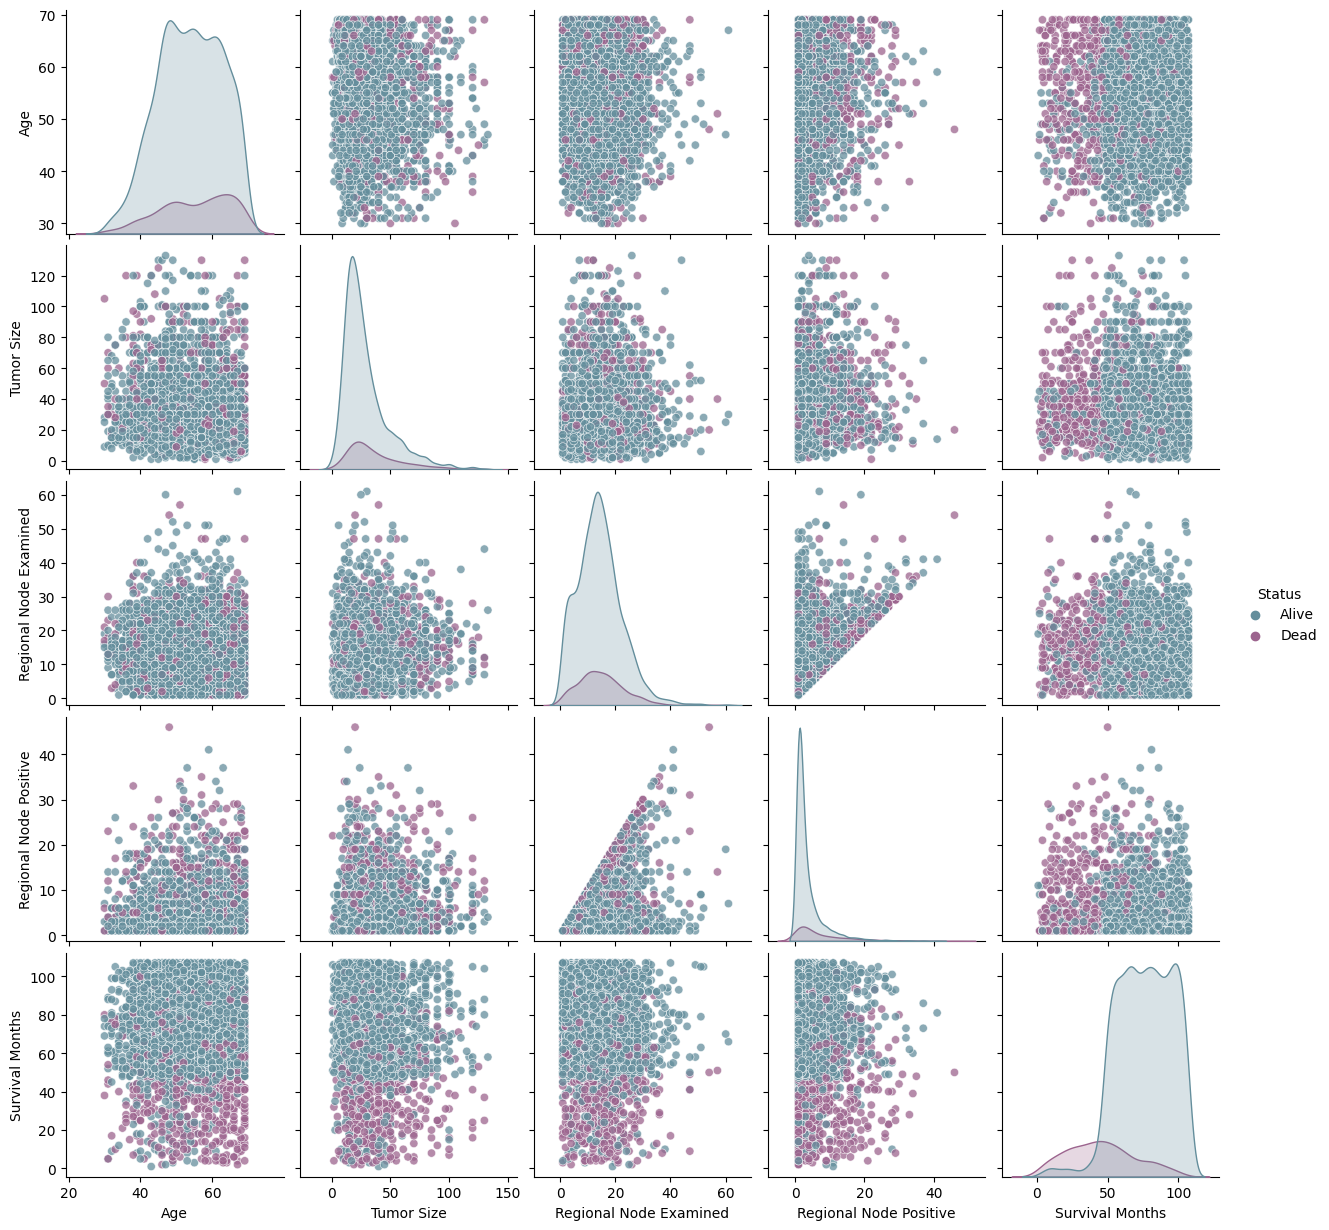

In [ ]:
bivariate_numerical_exploratory_analysis(bank_marketing, 'Status')

Before stating the colcusions of the generated figure, let's take a look at the *Corellation Heatmap* below as well.

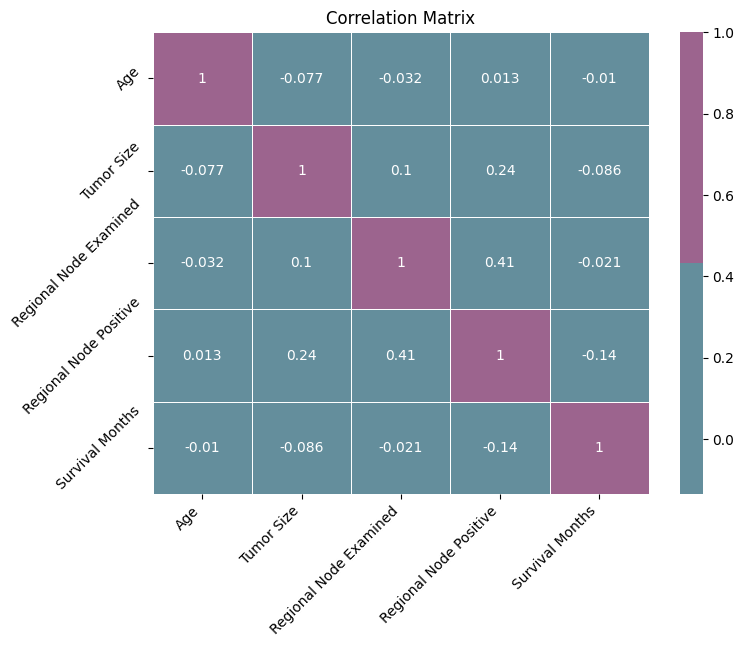

In [ ]:
correlation_heatmap(bank_marketing)

We see no strong correlation between numerical variables, some insights we can get, for example, are the following:


*   Considering the correlation between `Age` and `Tumor Size`, we can see that they are indipendent as the value indicated is **-0.077**.
*   The correlation between `Regional Node Examined` and `Regional Node Positive` indicates a moderate positive correlation of **0.412**, thus, as the number of regional nodes examined increases, the number of positive nodes also tends to increase.
*   The correlation between `Survival Months` and other variables is relatively weak. This indicates a weak or no linear relationship between survival months and the other numerical variables in the dataset.



However, by taking a look at the scatter plot of the numerical variables (before the correlation matrix), one can understand that the observations of `Alive` and `Dead` classes, are mixed when a combination of two numerical variables occurs. By that it is meant, that there is not clear separation between a pair of numerical variables for distinguishing `Alive` from `Dead` cases. The only interesting insight from the scatterplot occures for the variable `Survival Months`, which seems to generate a good separation boundary between the two classes, for all the combinations of the remaining numerical variables. This insight leads to the conclusion that the variable `Survival Months` can offer quite strong predictability power to the model.   

To continue with, in the next plot, the distribution of the categorical variables with respect to the target varible is presented.

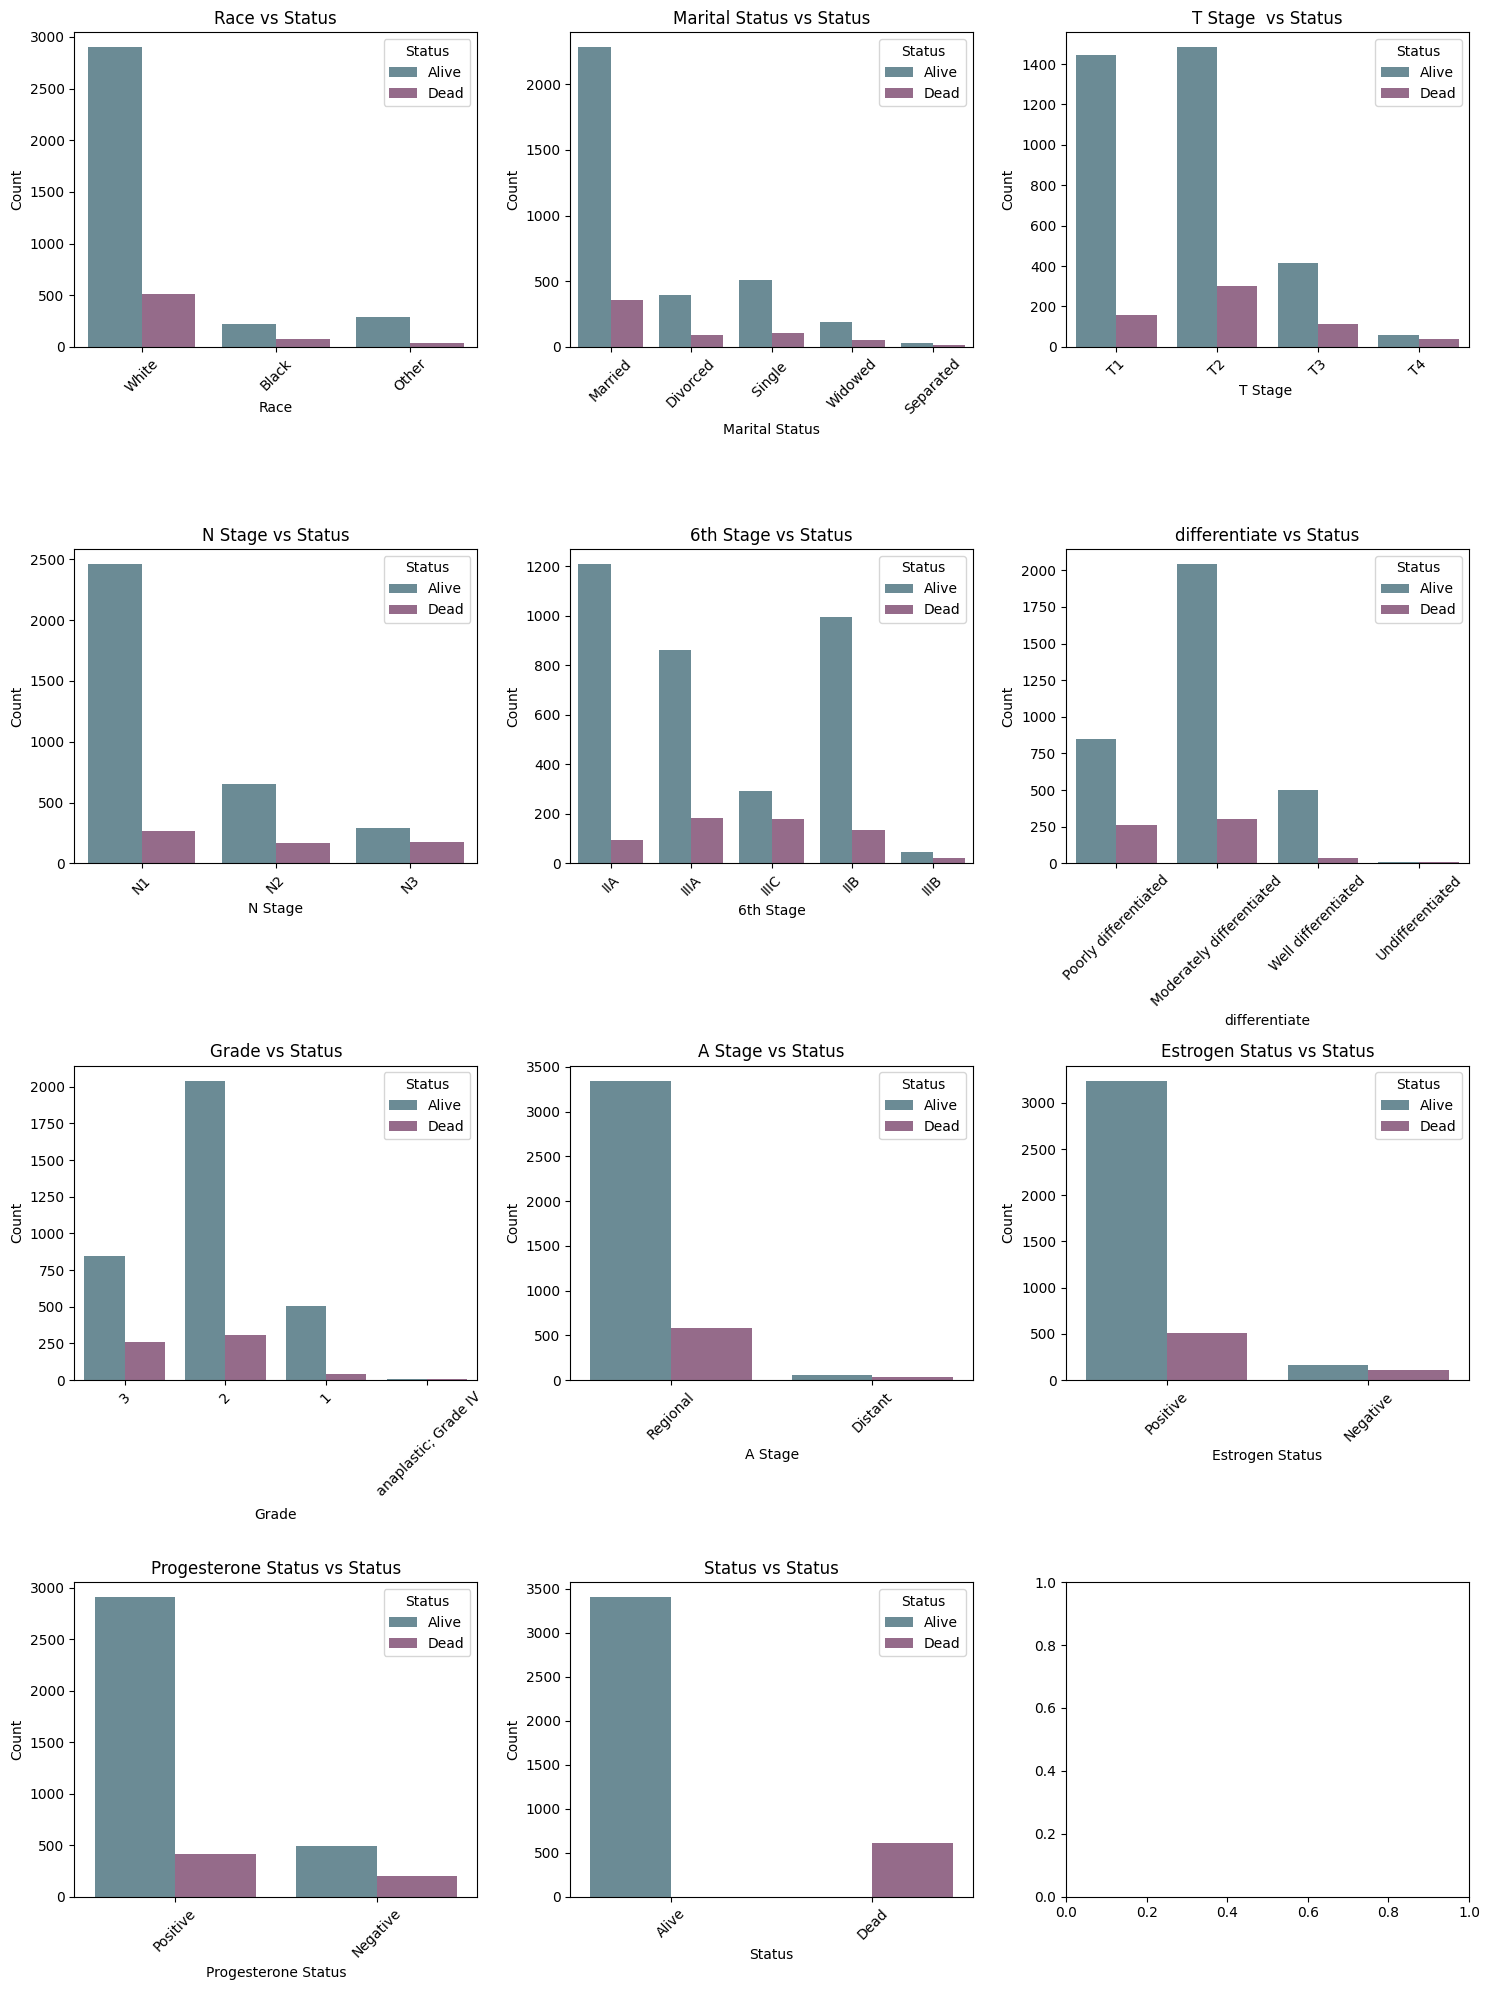

In [ ]:
plot_categorical_variables(bank_marketing, "Status")

Before conlcuding about the categorical variables, it is necessary to **statistically test** if correlation exist between them by using the `Chi-Squared` test.

In [ ]:
chi_squared_results = perform_chi_squared_test(bank_marketing, cat_cols)
print(chi_squared_results)
chi_squared_results.to_csv("./chi-2.csv")

    Variable 1           Variable 2  Chi-square       P-value
0         Race       Marital Status  137.649912  7.308896e-26
1         Race             T Stage     8.309501  2.162940e-01
2         Race              N Stage    6.215014  1.836560e-01
3         Race            6th Stage    8.923983  3.487492e-01
4         Race        differentiate   27.855377  1.000418e-04
..         ...                  ...         ...           ...
105     Status        differentiate  111.262966  5.868421e-24
106     Status                Grade  111.262966  5.868421e-24
107     Status              A Stage   35.795768  2.191234e-09
108     Status      Estrogen Status  135.274057  2.876016e-31
109     Status  Progesterone Status  125.062415  4.931880e-29

[110 rows x 4 columns]


By considering the barplots above, there is not clear conclusions to be made, due to the unbalanced nature of the dataset as mentioned earlier. However, some interesting insights generated by this figure is that for the variables `T Stage`, `N Stage` and `6th Stage`, it can be observed that for the categories `T4`, `N3` and `IIC`, respectively, the difference between the `Alive` and `Dead` cases, tend to get smaller, which might mean that these specific categories my help the model recognise patterns for `Dead` cases. Finally, it can be observed that in some of them, the probability of survival increases, for example, when the patient has a `T1` value for the `T Stage` variable.

In additoin, by taking a look at the produced `csv` file, the following conclusions can be derived:
1. `Race and Marital Status`: There is a significant association between race and marital status (Chi-square = 137.96, p < 0.001).
2. `Race and other variables`: Race does not show a significant association with T Stage, N Stage, 6th Stage, A Stage, or Progesterone Status. However, it is significantly associated with differentiation, grade, estrogen status, and overall status (p < 0.05).
3. `Marital Status and other variables`: Marital status is significantly associated with T Stage, N Stage, differentiation, grade, and overall status (p < 0.05).
4. `T Stage, N Stage, and other variables`: T Stage and N Stage are strongly associated with each other (Chi-square = 323.41, p < 0.001) and show significant associations with differentiation, grade, 6th Stage, A Stage, estrogen status, progesterone status, and overall status (p < 0.05).
5. `6th Stage and other variables`: 6th Stage is strongly associated with T Stage, N Stage, differentiation, grade, A Stage, estrogen status, progesterone status, and overall status (p < 0.001).
6. `Differentiation and other variables`: Differentiation is significantly associated with race, Marital Status, T Stage, N Stage, 6th Stage, grade, A Stage, estrogen status, progesterone status, and overall status (p < 0.05).
7. `Grade and other variables`: Grade is significantly associated with race, Marital Status, T Stage, N Stage, 6th Stage, differentiation, A Stage, estrogen status, progesterone status, and overall status (p < 0.05).
8. `A Stage and other variables`: A Stage shows a significant association with differentiation, estrogen status, and overall status (p < 0.05).
9. `Estrogen Status and other variables`: Estrogen status is significantly associated with race, T Stage, N Stage, 6th Stage, differentiation, grade, A Stage, progesterone status, and overall status (p < 0.05).
10. `Progesterone Status and other variables`: Progesterone status is significantly associated with race, Marital Status, T Stage, N Stage, 6th Stage, differentiation, grade, estrogen status, and overall status (p < 0.05).
11. `Overall Status and other variables`: Overall status is significantly associated with race, Marital Status, T Stage, N Stage, 6th Stage, differentiation, grade, A Stage, estrogen status, and progesterone status (p < 0.05).

## Multivariate Outliers Analysis

In addition, though, we'll perform a multivariate outlier detection using Mahalanobis Distance o the numerical variables of the dataset. In order to do so the calculation of the covariance matrix and its inverse is necessary in order to calculate the distances between the observations of the dataset.

In [ ]:
df_mahalanobis = bank_marketing[num_cols]
df_mahalanobis;

In [ ]:
df_mahalanobis = df_mahalanobis.to_numpy()

#Covariance matrix
cov_matrix = np.cov(df_mahalanobis, rowvar=False)
cov_matrix_pm1 = np.linalg.matrix_power(cov_matrix, -1)
centerpoint = np.mean(df_mahalanobis, axis=0)

The cutoff value for detecting outliers is set to **1%** based on the `Chi-Square distribution`. Thus, **0.99** represents the desired significance level.

In [ ]:
# Distances between center point 
distances = []
for i, val in enumerate(df_mahalanobis):
      p1 = val
      p2 = centerpoint
      distance = (p1-p2).T.dot(cov_matrix_pm1).dot(p1-p2)
      distances.append(distance)
distances = np.array(distances)

# Cutoff (threshold) value from Chi-Sqaure Distribution for detecting outliers 
cutoff = chi2.ppf(0.99, df_mahalanobis.shape[1])

# Index of outliers
outlierIndexes = np.where(distances > cutoff )

# print('--- Index of Outliers ----')
# print(outlierIndexes)

print('--- Number of Outliers ----')
print(len(outlierIndexes[0]))

df_multiv_outliers = df_mahalanobis[ distances > cutoff , :]

--- Number of Outliers ----
177


In [ ]:
bank_marketing.iloc[outlierIndexes[0]].describe(include='all')

Age   Race Marital Status T Stage  N Stage 6th Stage  \
count   177.000000    177            177      177     177       177   
unique         NaN      3              5        4       3         5   
top            NaN  White        Married       T3      N3      IIIC   
freq           NaN    155            101       73     106       106   
mean     54.254237    NaN            NaN      NaN     NaN       NaN   
std       9.893053    NaN            NaN      NaN     NaN       NaN   
min      30.000000    NaN            NaN      NaN     NaN       NaN   
25%      47.000000    NaN            NaN      NaN     NaN       NaN   
50%      55.000000    NaN            NaN      NaN     NaN       NaN   
75%      62.000000    NaN            NaN      NaN     NaN       NaN   
max      69.000000    NaN            NaN      NaN     NaN       NaN   

                    differentiate Grade   A Stage  Tumor Size Estrogen Status  \
count                         177   177       177  177.000000             177   
unique                          4     4         2         NaN               2   
top     Moderately differentiated     2  Regional         NaN        Positive   
freq                           89    89       159         NaN             152   
mean                          NaN   NaN       NaN   60.474576             NaN   
std                           NaN   NaN       NaN   40.255303             NaN   
min                           NaN   NaN       NaN    1.000000             NaN   
25%                           NaN   NaN       NaN   23.000000             NaN   
50%                           NaN   NaN       NaN   50.000000             NaN   
75%                           NaN   NaN       NaN  100.000000             NaN   
max                           NaN   NaN       NaN  133.000000             NaN   

       Progesterone Status  Regional Node Examined  Regional Node Positive  \
count                  177              177.000000              177.000000   
unique                   2                     NaN                     NaN   
top               Positive                     NaN                     NaN   
freq                   129                     NaN                     NaN   
mean                   NaN               26.960452               15.920904   
std                    NaN               12.472862               11.010556   
min                    NaN                3.000000                1.000000   
25%                    NaN               19.000000                5.000000   
50%                    NaN               26.000000               17.000000   
75%                    NaN               35.000000               25.000000   
max                    NaN               61.000000               46.000000   

        Survival Months Status  
count        177.000000    177  
unique              NaN      2  
top                 NaN  Alive  
freq                NaN    106  
mean          59.214689    NaN  
std           30.326803    NaN  
min            2.000000    NaN  
25%           37.000000    NaN  
50%           60.000000    NaN  
75%           83.000000    NaN  
max          107.000000    NaN

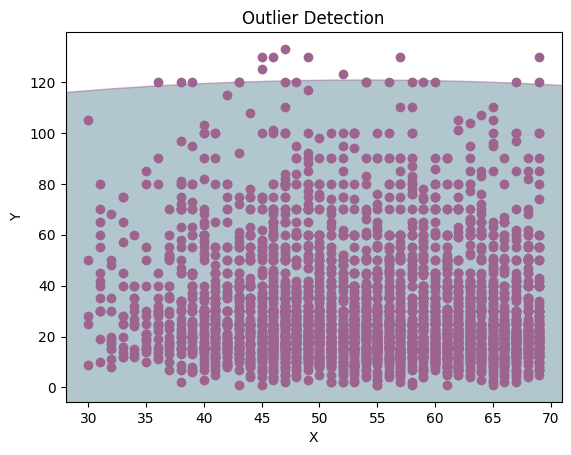

In [ ]:
## Finding ellipse dimensions 
pearson = cov_matrix[0, 1]/np.sqrt(cov_matrix[0, 0] * cov_matrix[1, 1])
ell_radius_x = np.sqrt(1 + pearson)
ell_radius_y = np.sqrt(1 - pearson)
lambda_, v = np.linalg.eig(cov_matrix)
lambda_ = np.sqrt(lambda_)

# Ellipse patch
ellipse = patches.Ellipse(xy=(centerpoint[0], centerpoint[1]),
                          width=lambda_[0]*np.sqrt(cutoff)*2, height=lambda_[1]*np.sqrt(cutoff)*2,
                          angle=np.rad2deg(np.arccos(v[0, 0])), edgecolor='#9C648E')
ellipse.set_facecolor('#648E9C')  # Set the facecolor to '#9C648E'
ellipse.set_alpha(0.5)

fig = plt.figure()
ax = plt.subplot()
ax.add_artist(ellipse)

# Scatter plot
plt.scatter(df_mahalanobis[:, 0], df_mahalanobis[:, 1], color='#9C648E')  # Set the scatter plot color to '#648E9C'

# Set plot title and labels
plt.title('Outlier Detection')
plt.xlabel('X')
plt.ylabel('Y')

plt.show();

As the above figure presents, based on the Mahalanobis distance and Chi-square distribution with 0.99 significance level, there are **177** multivariate outliers. After carefull consideration, by taking a look at those observations, we consider retaining them inside the dataset, since their maximum values seem logical. Although, we might return to this point in case of failures during the modelling phase.

***
# SECTION 5: Treatment of Mixed Data



With the following command it is clear that all categorical variables are set to be of type `object`.

In [ ]:
bank_marketing.dtypes

Age                        int64
Race                      object
Marital Status            object
T Stage                   object
N Stage                   object
6th Stage                 object
differentiate             object
Grade                     object
A Stage                   object
Tumor Size                 int64
Estrogen Status           object
Progesterone Status       object
Regional Node Examined     int64
Regional Node Positive     int64
Survival Months            int64
Status                    object
dtype: object

In [ ]:
print_categorical_variables(bank_marketing)

Categorical Variables:
Race: White, Black, Other
Marital Status: Married, Divorced, Single , Widowed, Separated
T Stage : T1, T2, T3, T4
N Stage: N1, N2, N3
6th Stage: IIA, IIIA, IIIC, IIB, IIIB
differentiate: Poorly differentiated, Moderately differentiated, Well differentiated, Undifferentiated
Grade: 3, 2, 1,  anaplastic; Grade IV
A Stage: Regional, Distant
Estrogen Status: Positive, Negative
Progesterone Status: Positive, Negative
Status: Alive, Dead


For presentation reasons, we are changing the value `anaplastic; Grade IV` of the variable Grade to `4`, and then all the values to latin numbers in order to be identical.

In [ ]:
bank_marketing['Grade'].replace(' anaplastic; Grade IV', '4', inplace=True)
bank_marketing['Grade'].replace({'1': 'I', '2': 'II', '3': 'III', '4': 'IV'}, inplace=True)

In [ ]:
print_categorical_variables(bank_marketing)

Categorical Variables:
Race: White, Black, Other
Marital Status: Married, Divorced, Single , Widowed, Separated
T Stage : T1, T2, T3, T4
N Stage: N1, N2, N3
6th Stage: IIA, IIIA, IIIC, IIB, IIIB
differentiate: Poorly differentiated, Moderately differentiated, Well differentiated, Undifferentiated
Grade: III, II, I, IV
A Stage: Regional, Distant
Estrogen Status: Positive, Negative
Progesterone Status: Positive, Negative
Status: Alive, Dead


Now it is necessary to create an order for the variables `T Stage`, `N Stage`, `6th Stage`, `differentiate`, and `Grade`.

In [ ]:
# Define the custom order for each categorical variable
t_stage_order = ['T1', 'T2', 'T3', 'T4']
n_stage_order = ['N1', 'N2', 'N3']
stage_6_order = ['IIA', 'IIB', 'IIIA', 'IIIB', 'IIIC']
differentiate_order = ['Undifferentiated', 'Poorly differentiated', 'Moderately differentiated', 'Well differentiated']
grade_order = ['I', 'II','III', 'IV']

# Apply the custom order to the categorical variables
bank_marketing['T Stage '] = pd.Categorical(bank_marketing['T Stage '], categories=t_stage_order, ordered=True)
bank_marketing['N Stage'] = pd.Categorical(bank_marketing['N Stage'], categories=n_stage_order, ordered=True)
bank_marketing['6th Stage'] = pd.Categorical(bank_marketing['6th Stage'], categories=stage_6_order, ordered=True)
bank_marketing['differentiate'] = pd.Categorical(bank_marketing['differentiate'], categories=differentiate_order, ordered=True)
bank_marketing['Grade'] = pd.Categorical(bank_marketing['Grade'], categories=grade_order, ordered=True)

# Print the updated order of the categorical variables
print("Categorical Variables with Custom Order:")
print("T Stage:", bank_marketing['T Stage '].cat.categories)
print("N Stage:", bank_marketing['N Stage'].cat.categories)
print("6th Stage:", bank_marketing['6th Stage'].cat.categories)
print("differentiate:", bank_marketing['differentiate'].cat.categories)
print("Grade:", bank_marketing['Grade'].cat.categories)

Categorical Variables with Custom Order:
T Stage: Index(['T1', 'T2', 'T3', 'T4'], dtype='object')
N Stage: Index(['N1', 'N2', 'N3'], dtype='object')
6th Stage: Index(['IIA', 'IIB', 'IIIA', 'IIIB', 'IIIC'], dtype='object')
differentiate: Index(['Undifferentiated', 'Poorly differentiated',
       'Moderately differentiated', 'Well differentiated'],
      dtype='object')
Grade: Index(['I', 'II', 'III', 'IV'], dtype='object')


In [ ]:
import warnings
# Get the summary of categorical data
summary = pd.DataFrame(columns=['Variable', 'Value', 'Count'])

# Iterate over each column
for column in bank_marketing.columns:
    # Check if the column is categorical
    if bank_marketing[column].dtype in ['object', 'category']:
        # Calculate the value counts
        value_counts = bank_marketing[column].value_counts().reset_index()
        value_counts.columns = ['Value', 'Count']

        # Add the variable name to the summary
        value_counts['Variable'] = column

        # Append to the summary DataFrame
        summary = pd.concat([summary, value_counts], ignore_index=True)

# Print the summary
print(summary)

               Variable                      Value Count
0                  Race                      White  3408
1                  Race                      Other   320
2                  Race                      Black   291
3        Marital Status                    Married  2639
4        Marital Status                    Single    615
5        Marital Status                   Divorced   485
6        Marital Status                    Widowed   235
7        Marital Status                  Separated    45
8              T Stage                          T2  1786
9              T Stage                          T1  1603
10             T Stage                          T3   529
11             T Stage                          T4   101
12              N Stage                         N1  2731
13              N Stage                         N2   817
14              N Stage                         N3   471
15            6th Stage                        IIA  1305
16            6th Stage        

***
# SECTION 6: Feature Extraction

From all the variables we have, we wanted to extract some new variables. Precisely, we will extract three categorical and one continuous (numerical):
- `Age Group`: We will group the age between 'Young', 'Middle-aged' and 'Elderly'
- `Race Group`: As there is a big gap between the number of pacients from different races, we will try to minimize a bit indicating if they are 'Caucasian' or 'Non-caucasian'
- `Tumor Stage Group`: We will group T1 into 'Early Stage' and T2, T3 and T4 into 'Advanced Stage'.

The continuous one will be the following:
- `Age at diagnosis`: When was the patient diagnosed
- `Positive lymph Ratio`: Ratio of positive to examined lymph nodes

In [ ]:
# Create a new column for Age Group based on custom age ranges
bank_marketing['Age Group'] = pd.cut(bank_marketing['Age'], bins=[30, 50, 60, np.inf], labels=['Young', 'Middle-aged', 'Elderly'])

# Print the updated dataframe with the Age Group variable
print(bank_marketing[['Age', 'Age Group']])
print(bank_marketing['Age Group'].value_counts())

      Age    Age Group
0      68      Elderly
1      50        Young
2      58  Middle-aged
3      58  Middle-aged
4      47        Young
...   ...          ...
4014   62      Elderly
4015   56  Middle-aged
4016   68      Elderly
4017   58  Middle-aged
4018   46        Young

[4019 rows x 2 columns]
Age Group
Young          1490
Middle-aged    1385
Elderly        1139
Name: count, dtype: int64


In order to have balanced data in this new variable, the boundaries set were the following:
- From 30 to 50 --> Young
- From 50 to 60 --> Middle-aged
- From 60 to ∞ --> Elderly

In [ ]:
# Create a new column for broader race groups
bank_marketing['Race Group'] = ''

# Assign the broader race group based on Race values
bank_marketing['Race Group'] = np.where(bank_marketing['Race'] == 'White', 'Caucasian', bank_marketing['Race Group'])
bank_marketing['Race Group'] = np.where(bank_marketing['Race'].isin(['Other', 'Black']), 'Non-Caucasian', bank_marketing['Race Group'])

# Print the updated dataframe with the Race and Race Group variables
print(bank_marketing[['Race', 'Race Group']])
print(bank_marketing['Race Group'].value_counts())

       Race     Race Group
0     White      Caucasian
1     White      Caucasian
2     White      Caucasian
3     White      Caucasian
4     White      Caucasian
...     ...            ...
4014  Other  Non-Caucasian
4015  White      Caucasian
4016  White      Caucasian
4017  Black  Non-Caucasian
4018  White      Caucasian

[4019 rows x 2 columns]
Race Group
Caucasian        3408
Non-Caucasian     611
Name: count, dtype: int64


In this second variable we consider splitting between 'Caucasian' and 'Non-caucasian' race. Even though we minimize the gap between races, it is still extense. We keep it for now.

In [ ]:
# Create a new column for Tumor Stage Group
bank_marketing['Tumor Stage Group'] = ''

# Assign the Tumor Stage Group based on T Stage values
bank_marketing['Tumor Stage Group'] = np.where(bank_marketing['T Stage ']=='T1', 'Early Stage', bank_marketing['Tumor Stage Group'])
bank_marketing['Tumor Stage Group'] = np.where(bank_marketing['T Stage '].isin([ 'T2', 'T3', 'T4']), 'Advanced Stage', bank_marketing['Tumor Stage Group'])

# Print the updated dataframe with the Tumor Stage Group variable
print(bank_marketing[['T Stage ', 'Tumor Stage Group']])
print(bank_marketing['Tumor Stage Group'].value_counts())


     T Stage  Tumor Stage Group
0          T1       Early Stage
1          T2    Advanced Stage
2          T3    Advanced Stage
3          T1       Early Stage
4          T2    Advanced Stage
...       ...               ...
4014       T1       Early Stage
4015       T2    Advanced Stage
4016       T2    Advanced Stage
4017       T2    Advanced Stage
4018       T2    Advanced Stage

[4019 rows x 2 columns]
Tumor Stage Group
Advanced Stage    2416
Early Stage       1603
Name: count, dtype: int64


In [ ]:
#Continuous
bank_marketing['Age at Diagnosis'] = bank_marketing['Age'] - (bank_marketing['Survival Months']//12)

In [ ]:
bank_marketing['Positive Lymph Ratio'] = bank_marketing['Regional Node Positive'] / bank_marketing['Regional Node Examined']


In [ ]:
bank_marketing.head(4)

Age   Race Marital Status T Stage  N Stage 6th Stage  \
0   68  White        Married       T1      N1       IIA   
1   50  White        Married       T2      N2      IIIA   
2   58  White       Divorced       T3      N3      IIIC   
3   58  White        Married       T1      N1       IIA   

               differentiate Grade   A Stage  Tumor Size  ...  \
0      Poorly differentiated   III  Regional           4  ...   
1  Moderately differentiated    II  Regional          35  ...   
2  Moderately differentiated    II  Regional          63  ...   
3      Poorly differentiated   III  Regional          18  ...   

  Progesterone Status Regional Node Examined  Regional Node Positive  \
0            Positive                     24                       1   
1            Positive                     14                       5   
2            Positive                     14                       7   
3            Positive                      2                       1   

   Survival Months  Status    Age Group Race Group Tumor Stage Group  \
0               60   Alive      Elderly  Caucasian       Early Stage   
1               62   Alive        Young  Caucasian    Advanced Stage   
2               75   Alive  Middle-aged  Caucasian    Advanced Stage   
3               84   Alive  Middle-aged  Caucasian       Early Stage   

  Age at Diagnosis  Positive Lymph Ratio  
0               63              0.041667  
1               45              0.357143  
2               52              0.500000  
3               51              0.500000  

[4 rows x 21 columns]

In [ ]:
#generate_cross_tabulations(bank_marketing, 'Status')

## Description of Final Dataset

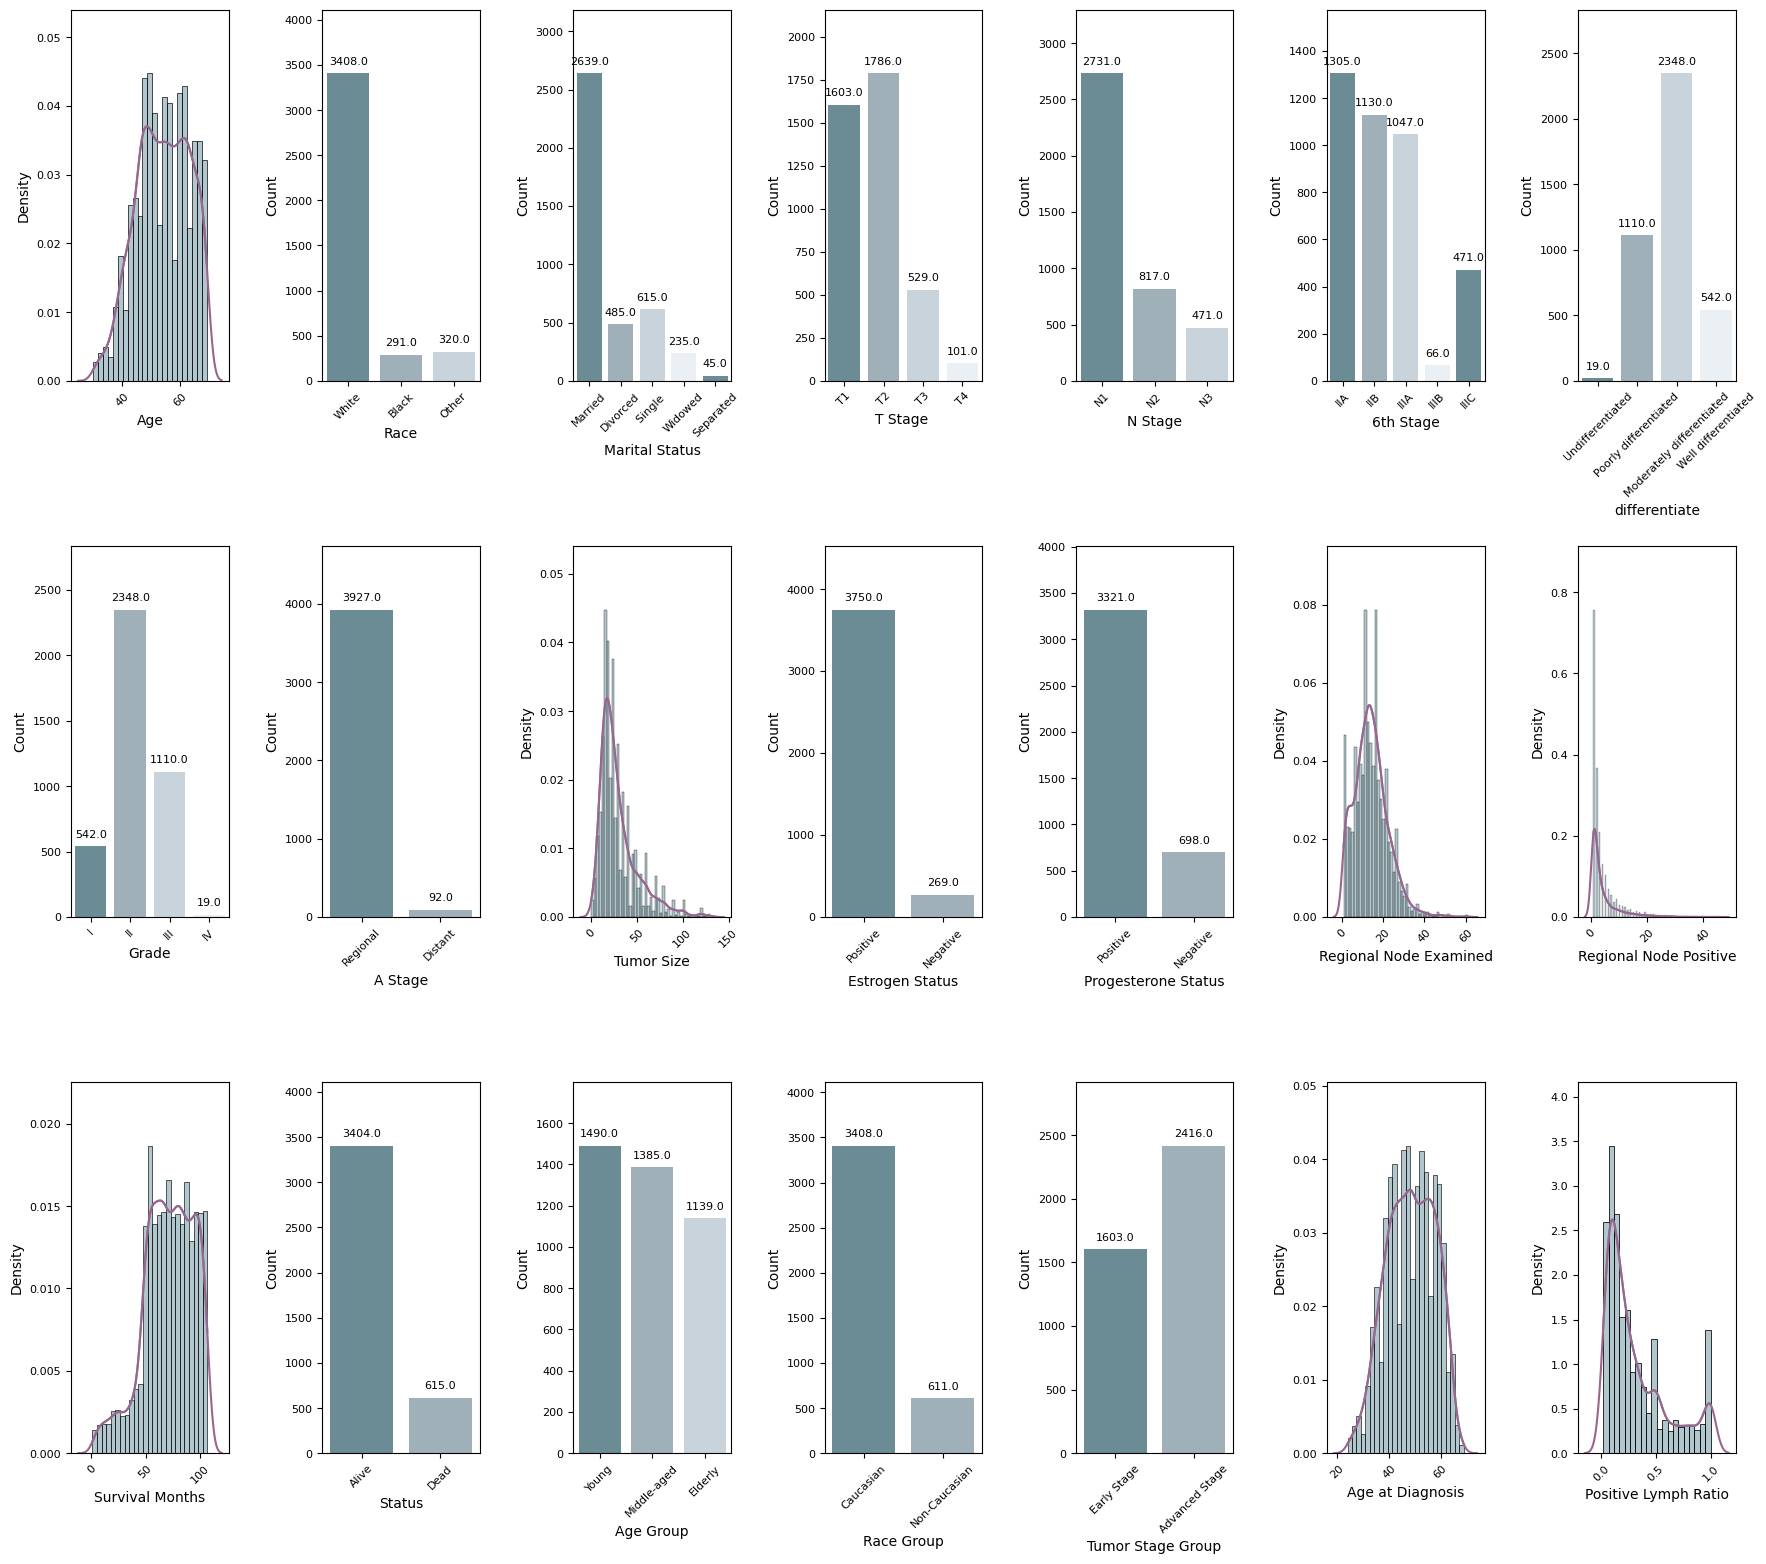

In [ ]:
plot_dataframe(bank_marketing,3,7)

One comment here that we would like to point out, is that we tried to normalize the variables `Tumor Size` and `Regional Node Positive` but the results of the sharipo test again give negative results. The code is excluded from this final deliverable.

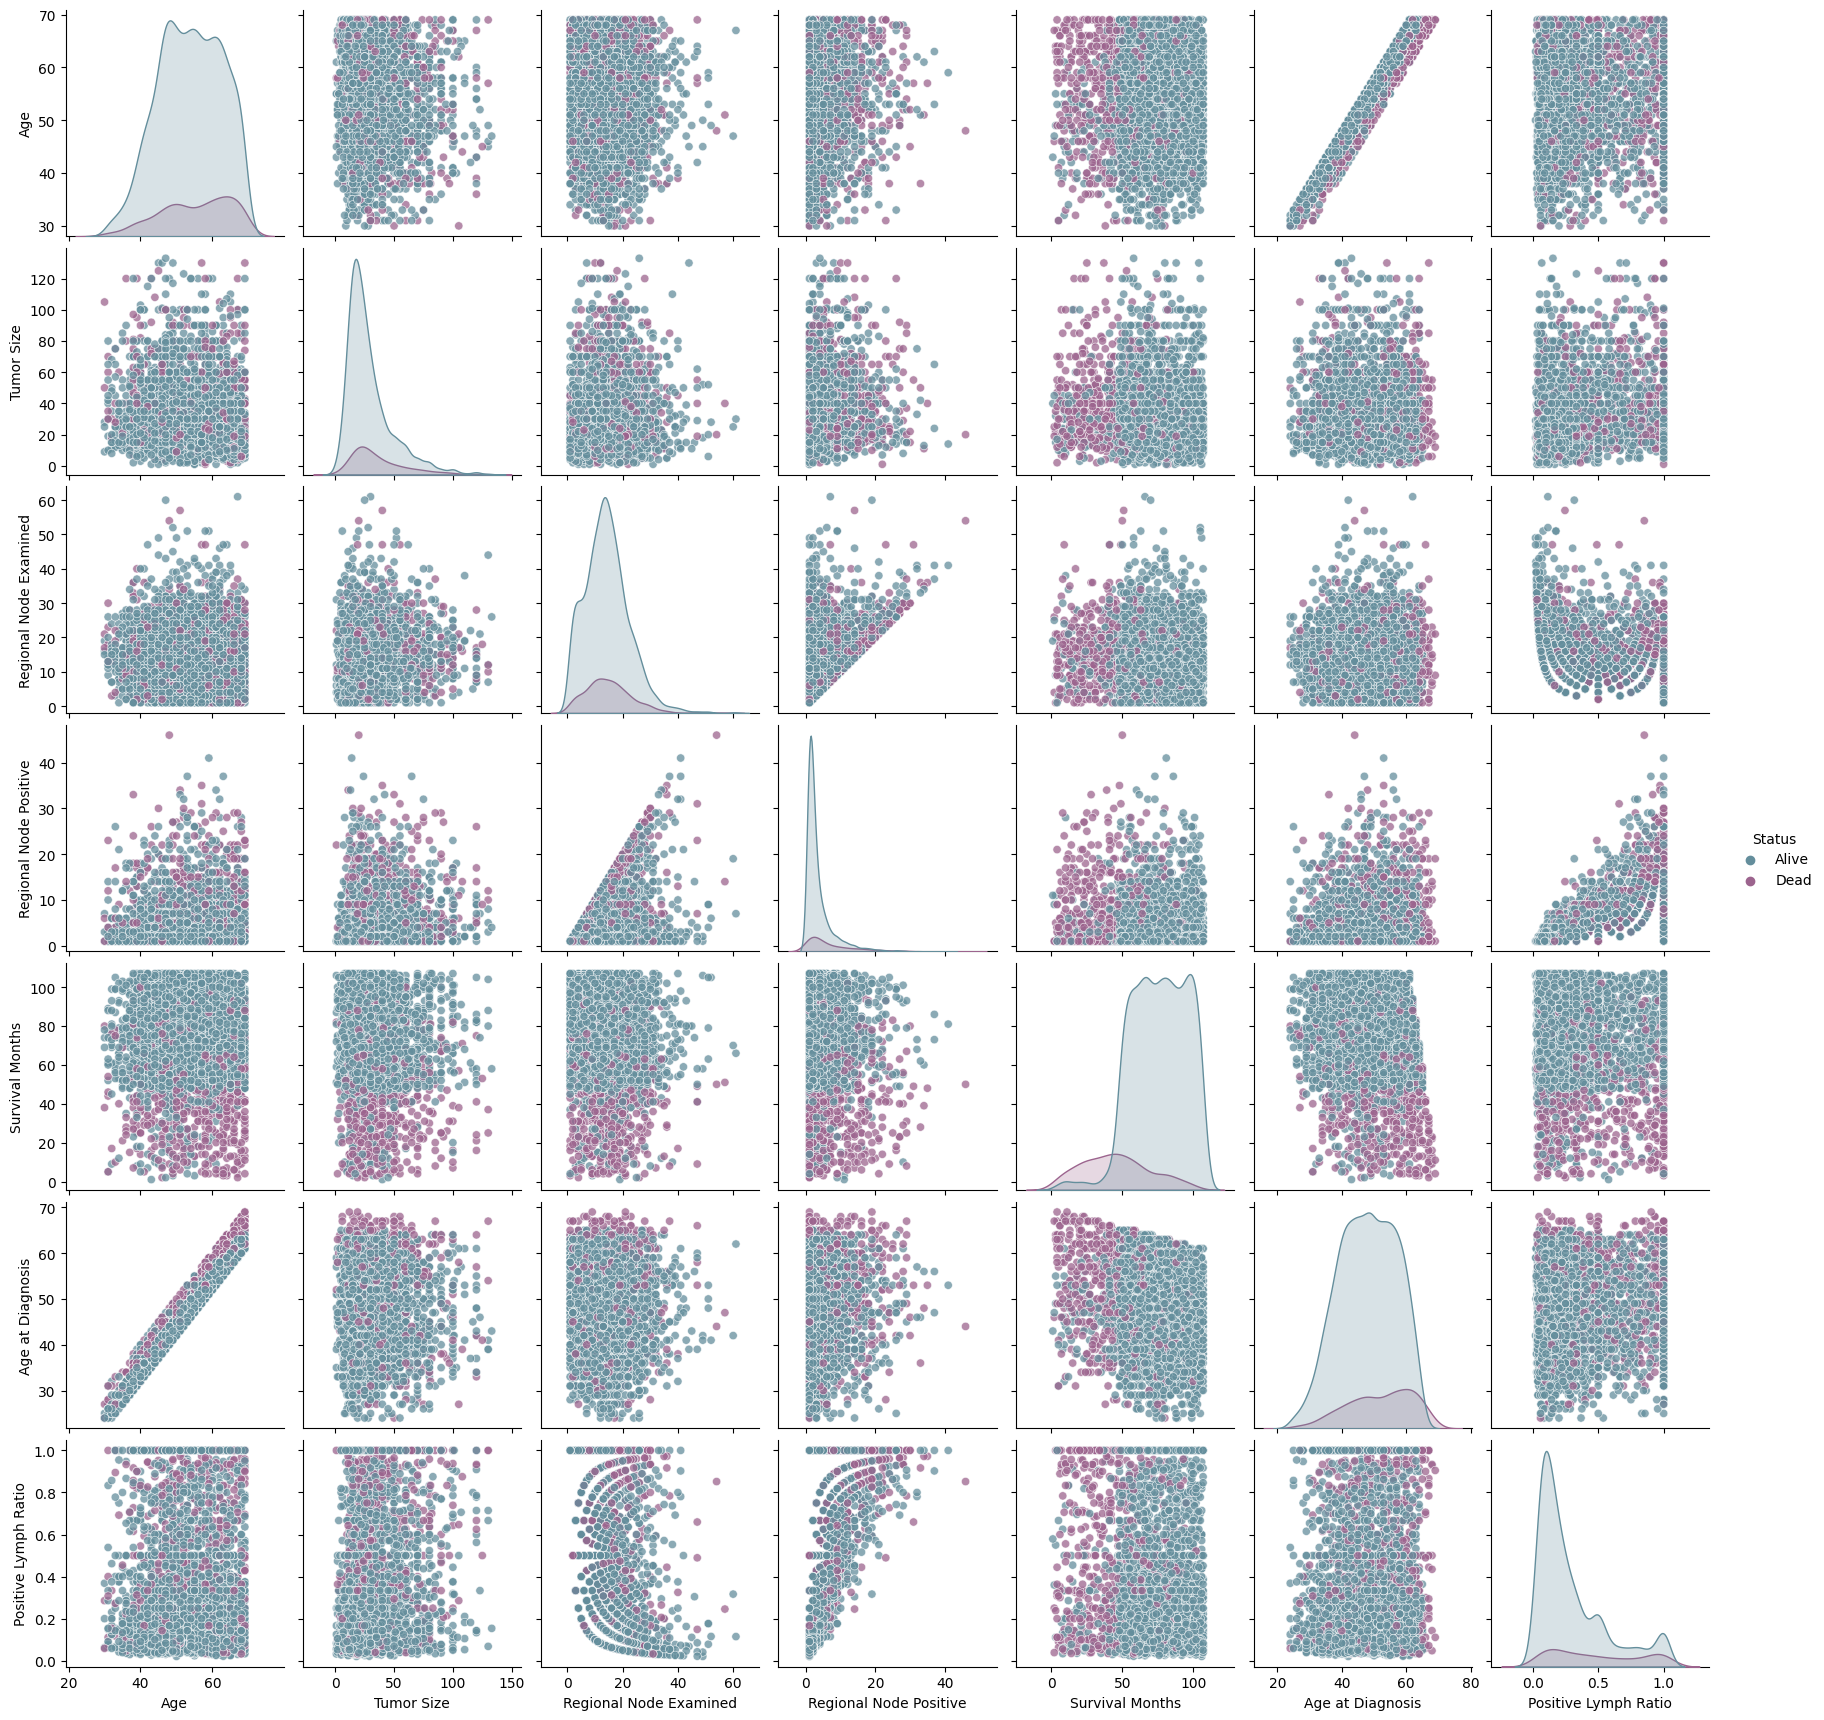

In [ ]:
bivariate_numerical_exploratory_analysis(bank_marketing, 'Status')

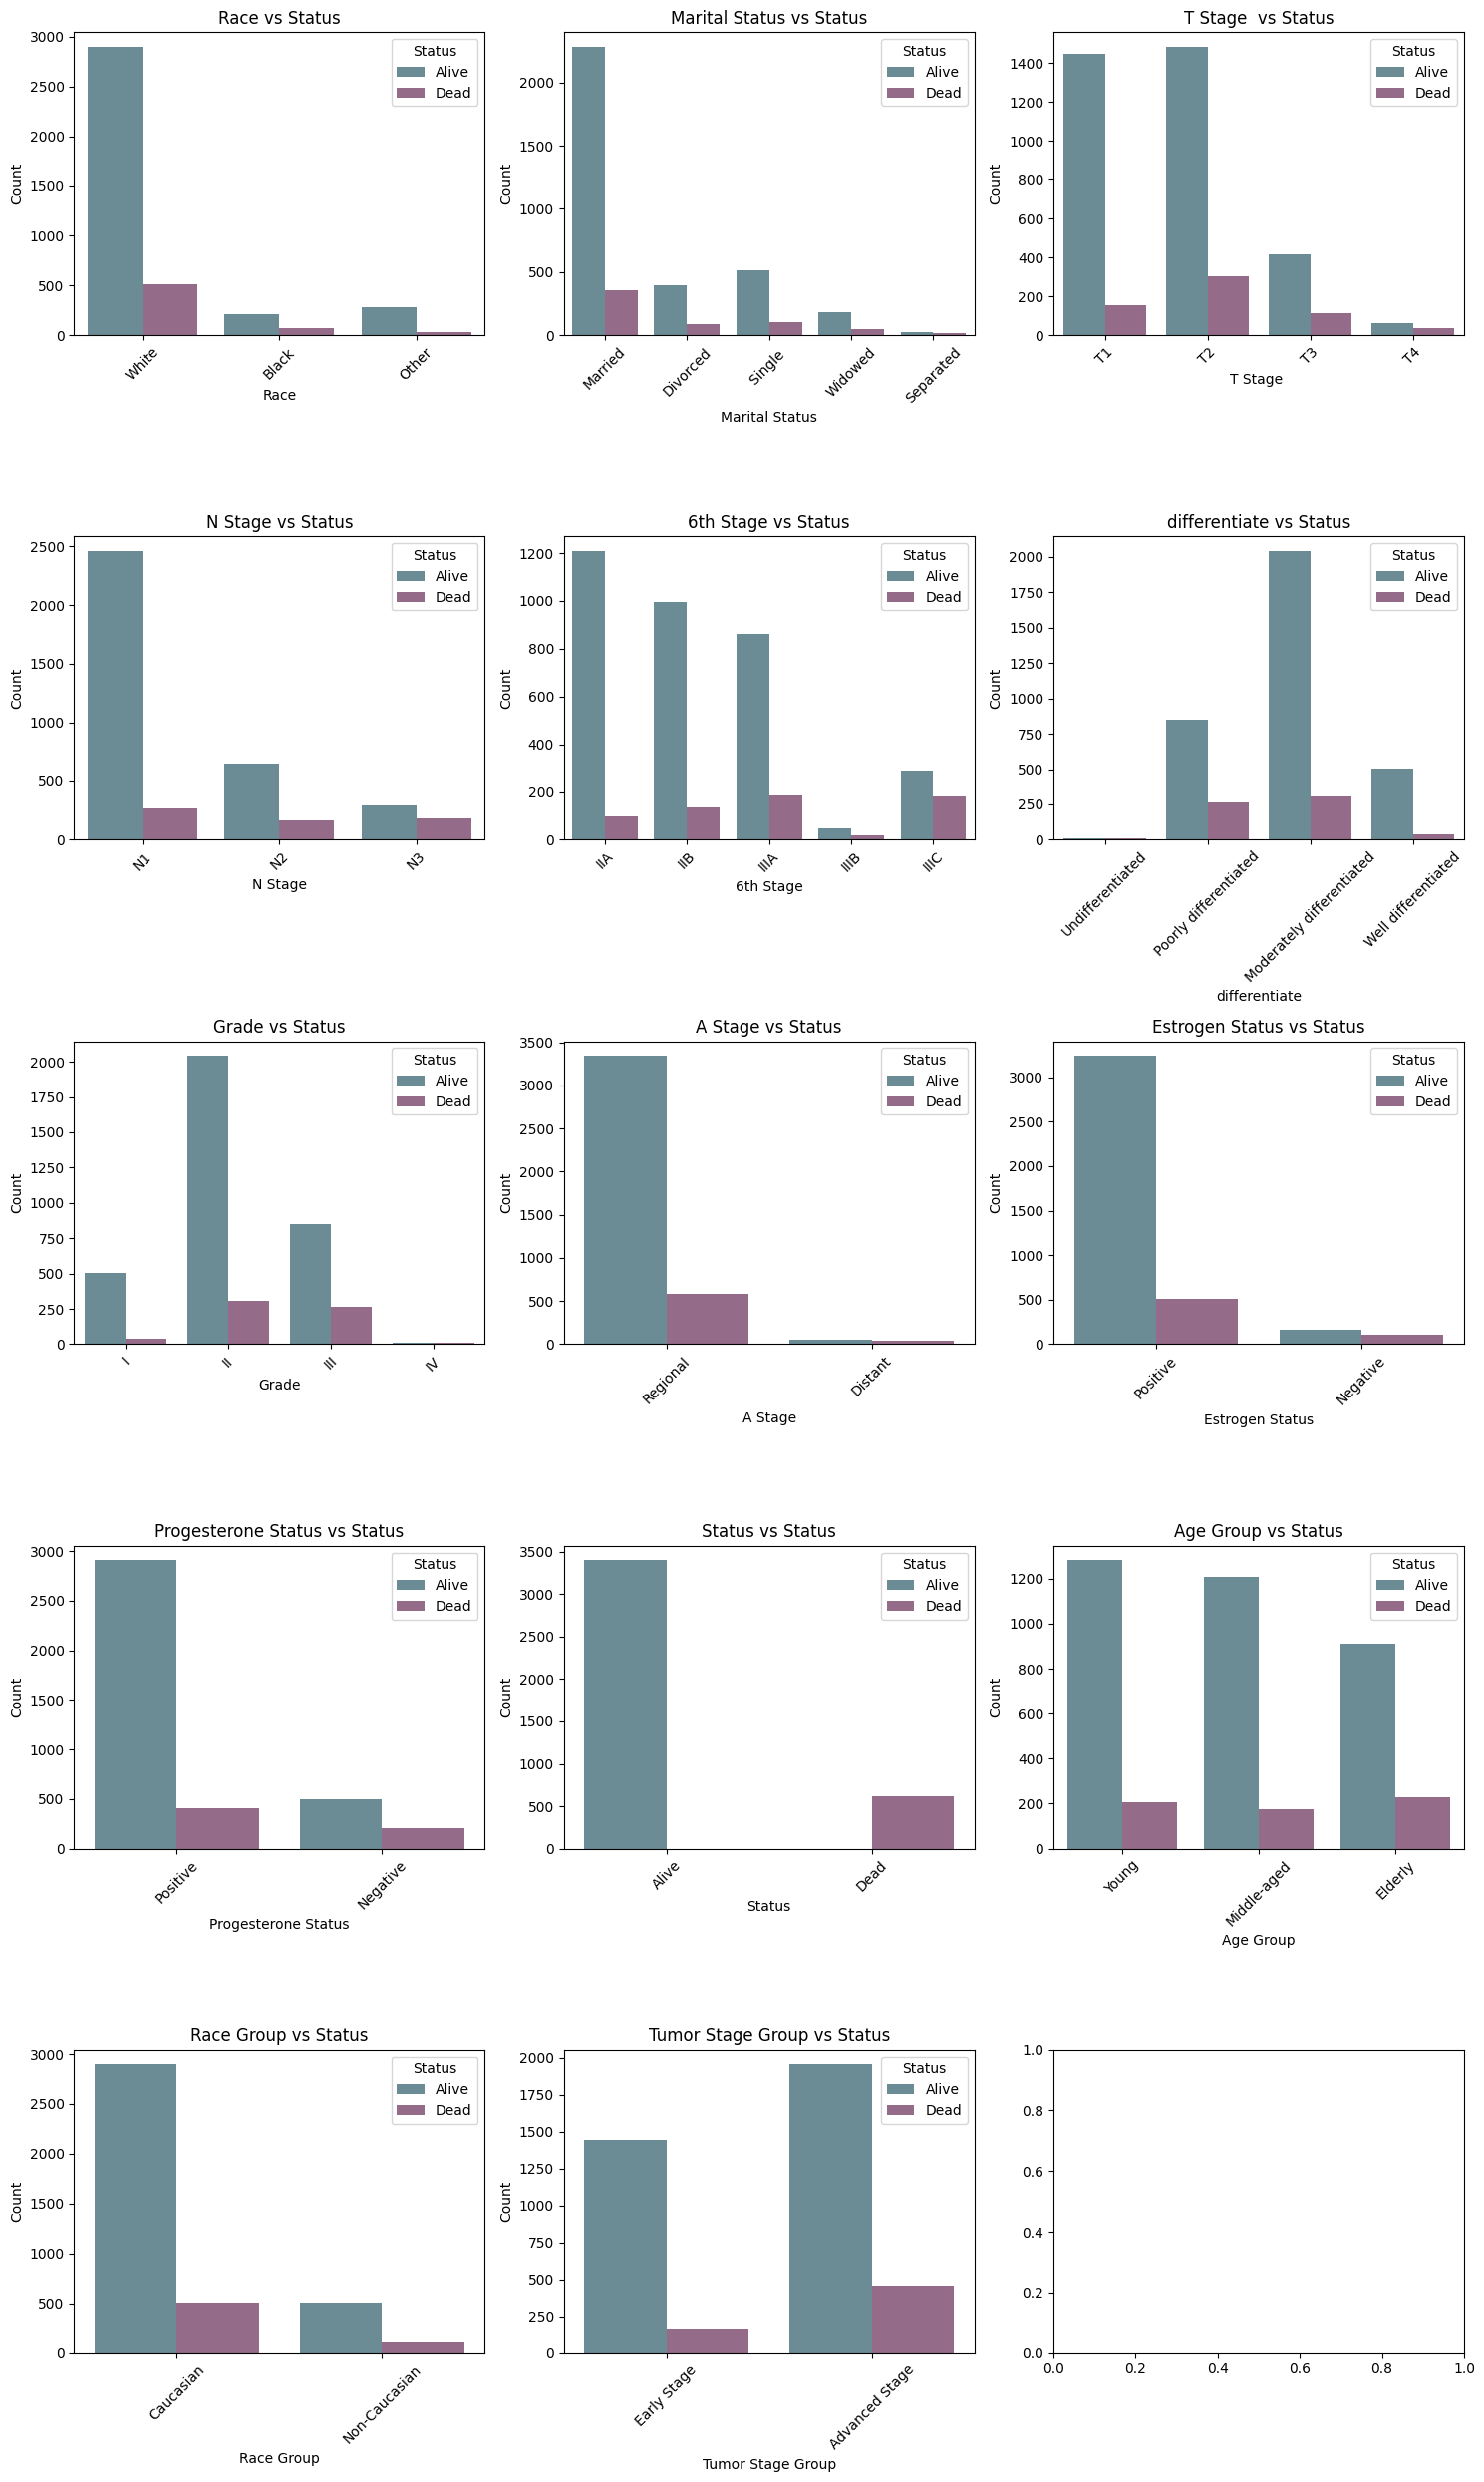

In [ ]:
plot_categorical_variables(bank_marketing, "Status")

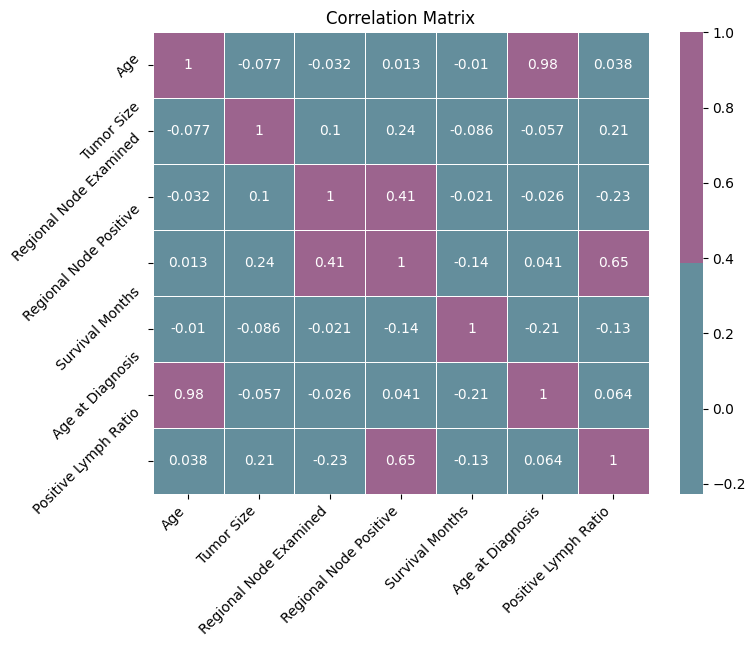

In [ ]:
correlation_heatmap(bank_marketing)

By following the same logic described during the `Univariate` and `Bivariate` analysis, conclusions can be derived for the new generated features.

***
# SECTION 7: Saving the Dataset

To prevent an oredered learning from our model, we will shuffle the data. Also, as we do not have a huge dataset and compression is not necessary, we will save the new data into a csv file.

## Important Note
It's important to note here that, the preprocessing (applying BoxCox transformation to `Tumor Size` and `Positive Lymph Ratio`, or `One-hot encoding` to categorical variables) as well as the normalization of the data with the `Min-Max Scaler` is taking place in the modelling notebooks, in order to be able to apply the transformations and the normalisation techniques on the training and test datasets separately.

In [ ]:
np.random.seed(666)
bank_marketing_new = bank_marketing.sample(frac=1).reset_index(drop=True)

In [ ]:
bank_marketing_new.to_csv('bank_marketing_new.csv', index=False)

In [ ]:
bank_marketing_read = read_csv("bank_marketing_new.csv", header=0, delimiter=',')

In [ ]:
bank_marketing_read.head(4)

Age   Race Marital Status T Stage  N Stage 6th Stage  \
0   57  White        Married       T4      N3      IIIC   
1   47  White        Married       T2      N1       IIB   
2   37  White        Single        T2      N1       IIB   
3   45  White        Married       T1      N1       IIA   

               differentiate Grade   A Stage  Tumor Size  ...  \
0      Poorly differentiated   III   Distant          85  ...   
1  Moderately differentiated    II  Regional          23  ...   
2  Moderately differentiated    II  Regional          23  ...   
3      Poorly differentiated   III  Regional          20  ...   

  Progesterone Status Regional Node Examined  Regional Node Positive  \
0            Positive                     31                      18   
1            Positive                      6                       5   
2            Positive                     17                       3   
3            Positive                     15                       1   

   Survival Months  Status    Age Group Race Group Tumor Stage Group  \
0               41   Alive  Middle-aged  Caucasian    Advanced Stage   
1               50   Alive        Young  Caucasian    Advanced Stage   
2               71   Alive        Young  Caucasian    Advanced Stage   
3               97   Alive        Young  Caucasian       Early Stage   

  Age at Diagnosis  Positive Lymph Ratio  
0               54              0.580645  
1               43              0.833333  
2               32              0.176471  
3               37              0.066667  

[4 rows x 21 columns]